In this notebook we are utilizing textual data of various articles that are either truthfull and factual texts or fake news. As you will see most of the articles are political news. Given this set we will try to make a model that is able to classify fake and true articles.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Fake news

/content/drive/MyDrive/Fake news


In [3]:
import zipfile
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import spearmanr

In [4]:
from preprocessing.text_processing_and_feature_engineering import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data loading

In [5]:
zip_path = "/content/drive/MyDrive/Fake news/data/DS44x.zip"
extract_path = "/content/extract/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
base_path = "/content/extract/archive"

In [7]:
true_csv_path = os.path.join(base_path, "True.csv")
false_csv_path = os.path.join(base_path, "Fake.csv")

true_data = pd.read_csv(true_csv_path)
false_data = pd.read_csv(false_csv_path)

In [8]:
true_data["label"] = "True"
false_data["label"] = "False"
combined_data = pd.concat([true_data, false_data], ignore_index=True)

### Data general cleaning

Missing or empty texts

Duplicated texts

In [9]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [10]:
missing_data = combined_data.isnull().sum()

In [11]:
print("Missing data:")
print(missing_data)

Missing data:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [12]:
empty_text_count = combined_data[combined_data['text'].str.strip() == ""].shape[0]

print(f"Number of empty rows: {empty_text_count}")

Number of empty rows: 631


In [13]:
empty_rows = combined_data[combined_data['text'].str.strip() == ""]

In [14]:
print("Label distribution of empty rows:")
print(empty_rows['label'].value_counts())

Label distribution of empty rows:
label
False    630
True       1
Name: count, dtype: int64


In [15]:
print("Subject distribution of empty rows:")
print(empty_rows['subject'].value_counts())

Subject distribution of empty rows:
subject
politics           408
left-news          150
Government News     72
politicsNews         1
Name: count, dtype: int64


In [16]:
empty_text_count_title = combined_data[combined_data['title'].str.strip() == ""].shape[0]

print(f"Number of empty titles rows: {empty_text_count_title}")

Number of empty titles rows: 0


Given that we have slight labels imbalance and few more false articles we are going to remove those rows that have empty text even though it has a title. We are considering these rows to be outliers and it could potentialy disrupt the model who is based on both title and text of the article when making a classification.

In [17]:
combined_data = combined_data[combined_data['text'].str.strip() != ""]

In [18]:
print(f"Dataset after removing empty 'text': {combined_data.shape}")

Dataset after removing empty 'text': (44267, 5)


In [19]:
duplicate_rows = combined_data[combined_data.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

Number of duplicate rows: 209


In [20]:
combined_data = combined_data.drop_duplicates(ignore_index=True)
print(f"Data after removing duplicates: {len(combined_data)}")

Data after removing duplicates: 44058


In [21]:
text_label_duplicates = combined_data[combined_data.duplicated(subset=['text', 'title', 'label'])]
print(f"Number of duplicates based on text title and label: {len(text_label_duplicates)}")

Number of duplicates based on text title and label: 5400


In [26]:
combined_data = combined_data.drop_duplicates(subset=['text', 'title', 'label'], keep='first')

print(f"Number of rows after removing duplicates: {len(combined_data)}")

Number of rows after removing duplicates: 38658


In [27]:
text_label_duplicates = combined_data[combined_data.duplicated(subset=['text', 'label'])]
print(f"Number of duplicates based on text and label: {len(text_label_duplicates)}")

Number of duplicates based on text and label: 14


In [25]:
text_label_duplicates_check = combined_data[combined_data.duplicated(subset=['text', 'label'], keep=False)]
print(f"Number of duplicates based on text and label: {len(text_label_duplicates_check)}")

Number of duplicates based on text and label: 28


In [28]:
grouped_duplicates = text_label_duplicates.groupby(['text', 'label'])

In [29]:
for group_key, group_rows in grouped_duplicates:
    print(f"Key: text and label: {group_key}")
    print("Duplicated rows:")
    print(group_rows)
    break

Key: text and label: ('(Reuters) - Republicans in the U.S. Congress reached a deal on final tax legislation on Wednesday, clearing the way for final votes next week on a package that, if approved, would be sent to President Donald Trump to sign into law. Formal language of the legislation has not been released. The following are known provisions on which House of Representatives and Senate tax writers have agreed, based on conversations with aides and lawmakers: CORPORATE TAX RATE: Falls to 21 percent from 35 percent. The House and Senate bills, as well as Trump, had earlier proposed 20 percent. Going to 21 percent gave tax writers more federal revenue needed to make the tax cut immediate. U.S. corporations have been seeking a large tax cut like this for many years.  PASS-THROUGH BUSINESSES: Creates a 20 percent business income deduction for owners of pass-through businesses, such as sole proprietorships and partnerships. The House had proposed a 25 percent tax rate; the Senate, a 23 p

In [30]:
combined_data = combined_data.drop_duplicates(subset=['text','label'], keep='first')

print(f"Number of rows after removing duplicates: {len(combined_data)}")

Number of rows after removing duplicates: 38644


In [31]:
conflicting_rows = combined_data.groupby(['title', 'text'])['label'].nunique()
conflicting_rows = conflicting_rows[conflicting_rows > 1]
conflicting_rows

Series([], Name: label, dtype: int64)

In [32]:
conflict_data = combined_data[combined_data.set_index(['title', 'text']).index.isin(conflicting_rows.index)]
print(f"Number of rows with the same title and text but different label: {len(conflict_data)}")

Number of rows with the same title and text but different label: 0


In [33]:
print(f"Number of rows after removing duplicates: {len(combined_data)}")

Number of rows after removing duplicates: 38644


### EDA

In [36]:
combined_data.head(10)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   
7  Factbox: Trump on Twitter (Dec 29) - Approval ...   
8         Trump on Twitter (Dec 28) - Global Warming   
9  Alabama official to certify Senator-elect Jone...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
5  WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...  politicsNews   
6  WEST PALM BEACH, Fla (Reuters) - President Don...  politicsNews   
7  The following statements were posted to the ve...  politicsNews   
8  The following statements were posted to the ve...  politicsNews   
9  WASHINGTON (Reuters) - Alabama Secretary of St...  politicsNews   

                 date label  
0  December 31, 2017   True  
1  December 29, 2017   True  
2  December 31, 2017   True  
3  December 30, 2017   True  
4  December 29, 2017   True  
5  December 29, 2017   True  
6  December 29, 2017   True  
7  December 29, 2017   True  
8  December 29, 2017   True  
9  December 28, 2017   True

We can see that a lot of text are possibly from reuters and source is indicated in the text.

In [37]:
combined_data.tail(10)

title  \
43270  McPain: John McCain Furious That Iran Treated ...   
43271  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
43272  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
43273  How to Blow $700 Million: Al Jazeera America F...   
43274  10 U.S. Navy Sailors Held by Iranian Military ...   
43275  The White House and The Theatrics of ‘Gun Cont...   
43276  Activists or Terrorists? How Media Controls an...   
43277  BOILER ROOM – No Surrender, No Retreat, Heads ...   
43278  Federal Showdown Looms in Oregon After BLM Abu...   
43279  A Troubled King: Chicago’s Rahm Emanuel Desper...   

                                                    text  subject  \
43270  21st Century Wire says As 21WIRE reported earl...  US_News   
43271  21st Century Wire says It s a familiar theme. ...  US_News   
43272  Patrick Henningsen  21st Century WireRemember ...  US_News   
43273  21st Century Wire says Al Jazeera America will...  US_News   
43274  21st Century Wire says As 21WIRE predicted in ...  US_News   
43275  21st Century Wire says All the world s a stage...  US_News   
43276    Randy Johnson 21st Century WireThe majority ...  US_News   
43277  Tune in to the Alternate Current Radio Network...  US_News   
43278  21st Century Wire says A new front has just op...  US_News   
43279  21st Century Wire says It s not that far away....  US_News   

                   date  label  
43270  January 16, 2016  False  
43271  January 16, 2016  False  
43272  January 15, 2016  False  
43273  January 14, 2016  False  
43274  January 12, 2016  False  
43275   January 7, 2016  False  
43276   January 7, 2016  False  
43277   January 6, 2016  False  
43278   January 4, 2016  False  
43279   January 2, 2016  False

Here fake text are from 21st century wire.

In [38]:
label_counts = combined_data['label'].value_counts()
labels = label_counts.index.tolist()
counts = label_counts.values.tolist()

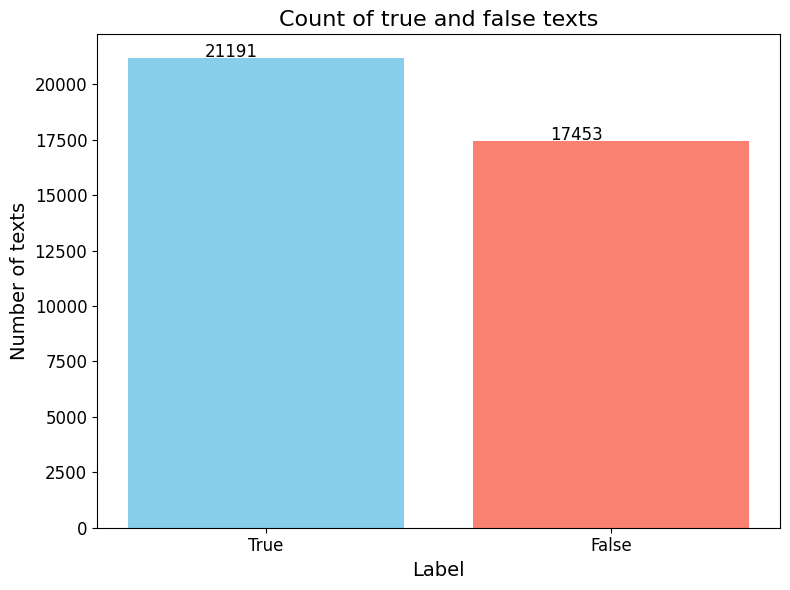

In [39]:
plt.figure(figsize=(8, 6))
bars = plt.bar(labels,
               counts,
               color=['skyblue', 'salmon'])
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 50,
             str(bar.get_height()),
             ha='center',
             fontsize=12)

plt.title('Count of true and false texts', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Number of texts', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

After removing duplicated and empty texts we have checked the labels proportions and we can see that we have slightly more true articles than false ones.

In [40]:
subject_counts = combined_data.groupby(['label', 'subject'])['subject'].count().unstack()

In [41]:
subject_counts_transposed = subject_counts.T

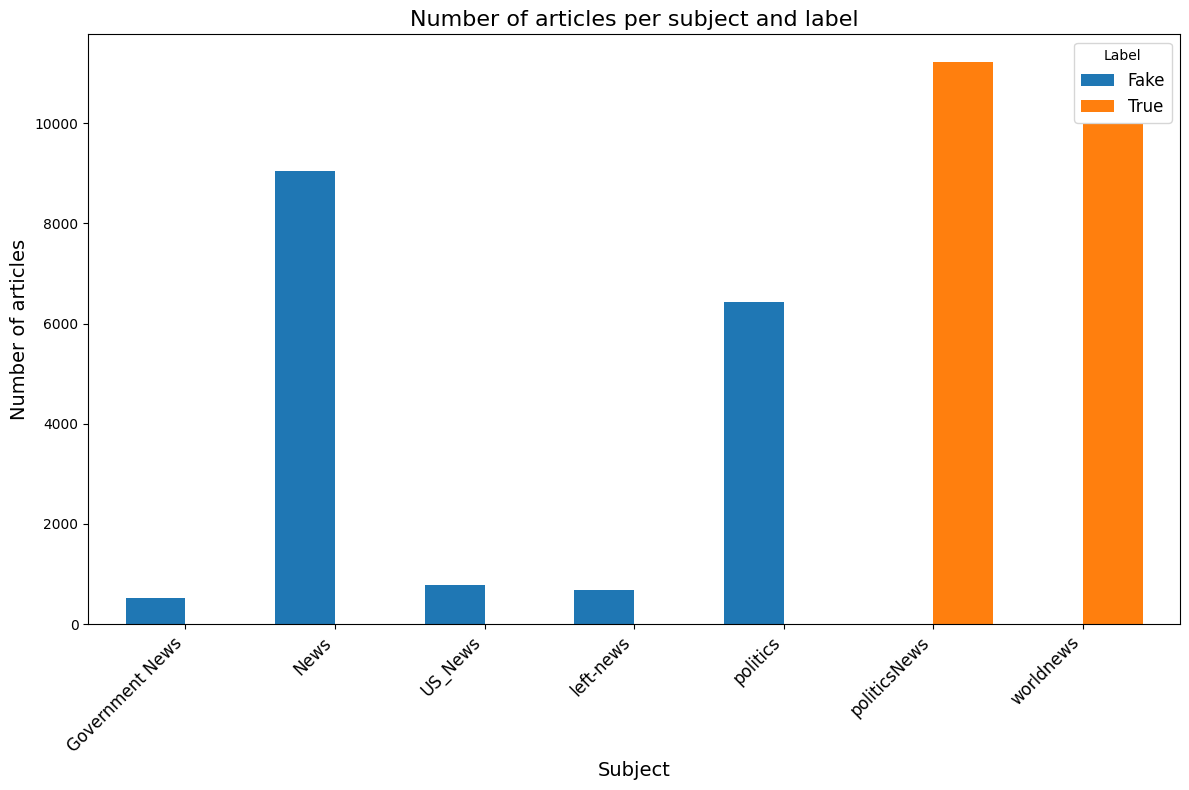

In [42]:
subject_counts_transposed.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title("Number of articles per subject and label", fontsize=16)
plt.xlabel("Subject", fontsize=14)
plt.ylabel("Number of articles", fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.legend(title="Label", labels=["Fake", "True"], fontsize=12)
plt.tight_layout()
plt.show()

From the subject analysis we can see that texts are most about politics and in general news. We will be able to see more when we look into the context more using word cloud.

Cleaning text to create word cloud: removing symbols, unifying by lowercasing, masking numbers as <NUMBER> as well hyperlinks

### Word cloud

We are going to standartize and clean textual data by lowercasing letters, will replace Urls with URL placeholder and do same for numbers. We are also going to remove non letters characters to simplify the text and excessive whitespaces if there are any. This will be saved as additional text that we will be working on some cases and possibly models.

In [43]:
combined_data['cleaned_text'] = combined_data['text'].apply(normalize_text)

In [44]:
combined_data['cleaned_title'] = combined_data['title'].apply(normalize_text)

Additional we are going to remove stop words and save it seperately as well.

In [45]:
combined_data['cleaned_and_without_stop_text'] = combined_data['cleaned_text'].apply(remove_stopwords)

In [46]:
combined_data['cleaned_and_without_stop_title'] = combined_data['cleaned_title'].apply(remove_stopwords)

In [47]:
empty_cleaned_text_count = combined_data[combined_data['cleaned_and_without_stop_text'].str.strip() == ""].shape[0]

print(f"Number of rows with empty cleaned_text: {empty_cleaned_text_count}")

Number of rows with empty cleaned_text: 54


In [48]:
combined_data = combined_data[combined_data['cleaned_and_without_stop_text'].str.strip() != ""]

In [49]:
empty_cleaned_title_count = combined_data[combined_data['cleaned_and_without_stop_title'].str.strip() == ""].shape[0]

print(f"Number of rows with empty cleaned_title: {empty_cleaned_title_count}")

Number of rows with empty cleaned_title: 0


We are going to have a look at the most common words in each label using word cloud.

In [50]:
true_text = " ".join(combined_data[combined_data['label'] == "True"]['cleaned_and_without_stop_text'])
false_text = " ".join(combined_data[combined_data['label'] == "False"]['cleaned_and_without_stop_text'])

In [51]:
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)
false_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(false_text)

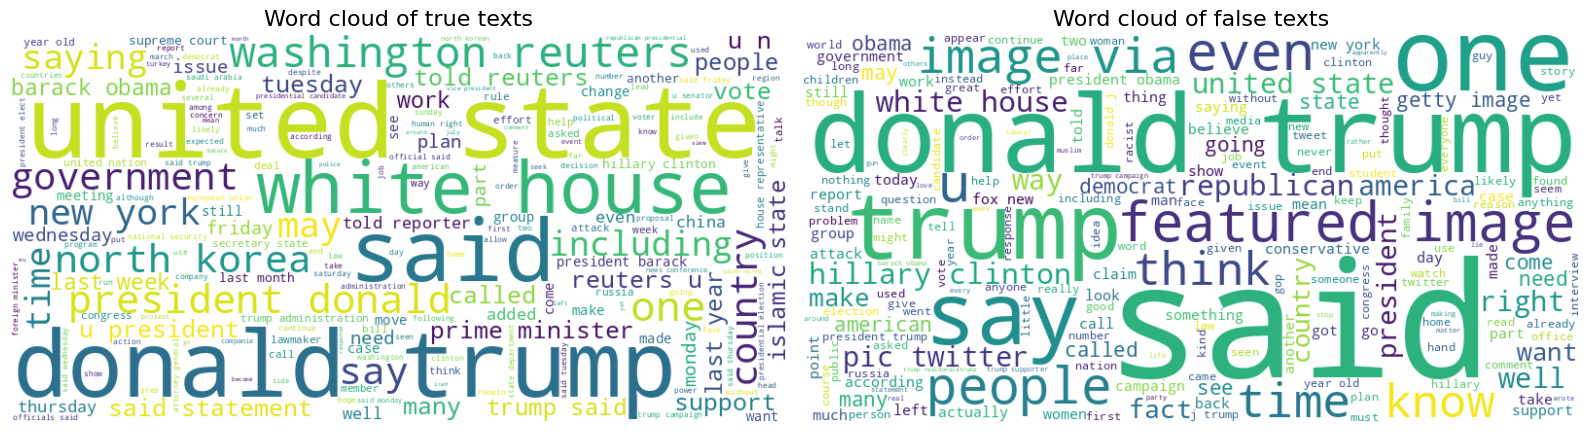

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title("Word cloud of true texts", fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(false_wordcloud, interpolation='bilinear')
plt.title("Word cloud of false texts", fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

As per subjects analysis we can see that most of the words in the text are about politics. in both true and false articles we can contraversial donal trump constantly mentioned. As well we can see that a lot of true articles are comming from washington reuters. We can see some geographic locations appearing as offenly mentioned like north korea or new york. On the false side we can see twitter and fox news mentioned as well as many other politicans like hilary clinton. Also we can see word people in that cloud while on true side it does seem to be appearing. So there are quite a lot of disinguishing words in these labels, if we base our model on the context itself it can lead to bias results, given that we have very topic specific data set.  

In [53]:
true_title_text = " ".join(combined_data[combined_data['label'] == "True"]['cleaned_and_without_stop_title'])
false_title_text = " ".join(combined_data[combined_data['label'] == "False"]['cleaned_and_without_stop_title'])

In [54]:
true_title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_title_text)
false_title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(false_title_text)

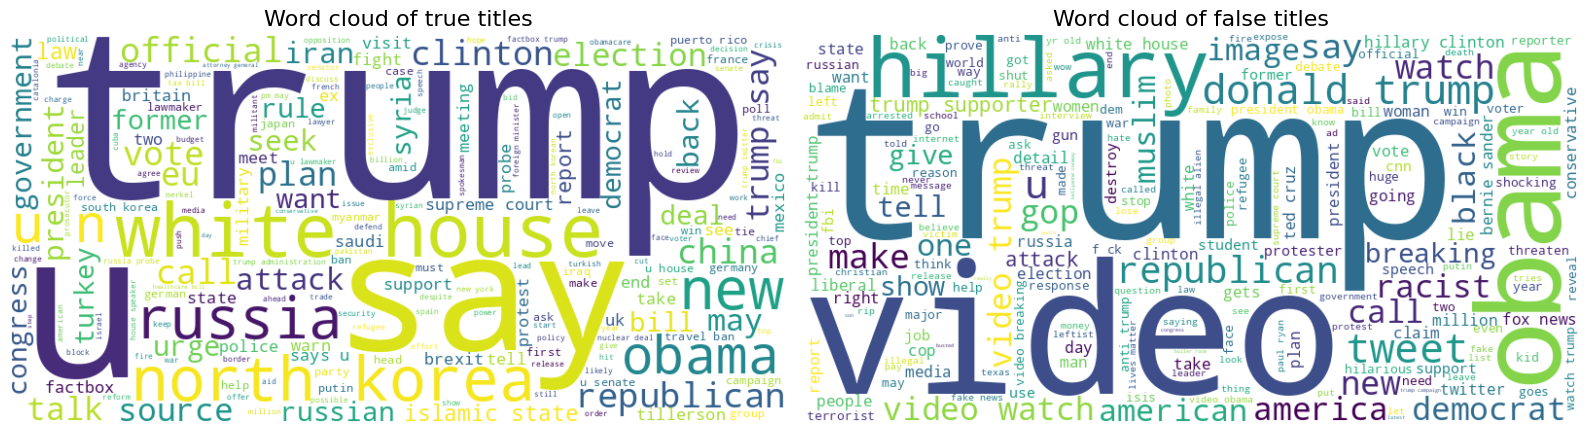

In [55]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(true_title_wordcloud, interpolation='bilinear')
plt.title("Word cloud of true titles", fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(false_title_wordcloud, interpolation='bilinear')
plt.title("Word cloud of false titles", fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

If we look how most common words in titles look we can see that as in text trump word is dominating both labels, difference is that title very commenly has video mentioned meanwhile true articles have white house as news are mostly about USA and does the correspondence.

### Basic text statistics

In [56]:
combined_data['char_count'] = combined_data['text'].apply(len)

In [57]:
combined_data['word_count'] = combined_data['text'].apply(lambda x: len(x.split()))

In [58]:
combined_data['unique_word_count'] = combined_data['text'].apply(lambda x: len(set(x.split())))

In [59]:
stats_per_class = combined_data.groupby('label').agg({
    'char_count': 'mean',
    'word_count': 'mean',
    'unique_word_count': 'mean'
}).reset_index()

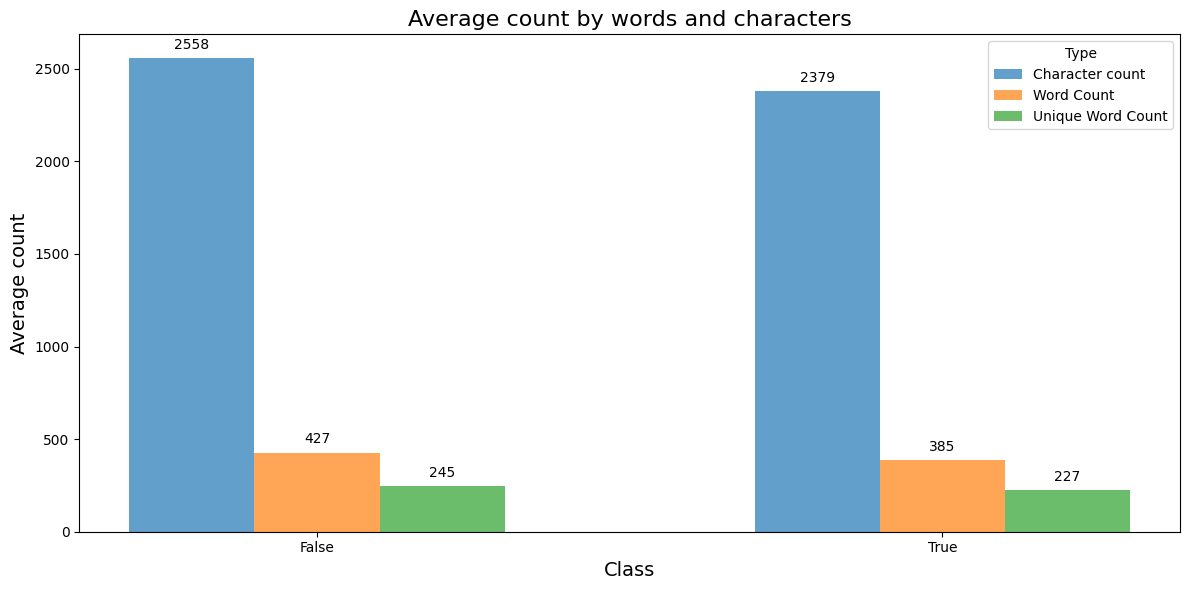

In [60]:
plt.figure(figsize=(12, 6))
labels = stats_per_class['label']
x = range(len(labels))
width = 0.2

bars_char = plt.bar(x, stats_per_class['char_count'], width, label='Character count', alpha=0.7)
bars_word = plt.bar([p + width for p in x], stats_per_class['word_count'], width, label='Word Count', alpha=0.7)
bars_unique = plt.bar([p + 2 * width for p in x], stats_per_class['unique_word_count'], width, label='Unique Word Count', alpha=0.7)

for bar in bars_char:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50,
             f"{bar.get_height():.0f}", ha='center', fontsize=10)

for bar in bars_word:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50,
             f"{bar.get_height():.0f}", ha='center', fontsize=10)

for bar in bars_unique:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50,
             f"{bar.get_height():.0f}", ha='center', fontsize=10)

plt.xticks([p + width for p in x], labels)
plt.title("Average count by words and characters", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Average count", fontsize=14)
plt.legend(title="Type")
plt.tight_layout()
plt.show()

False text have a bit more words, characters and unique words.

Let's have a look how different are titles in each label.

In [61]:
combined_data['title_char_count'] = combined_data['title'].apply(len)

In [62]:
combined_data['title_word_count'] = combined_data['title'].apply(lambda x: len(x.split()))

In [63]:
combined_data['title_unique_word_count'] = combined_data['title'].apply(lambda x: len(set(x.split())))

In [64]:
stats_per_class_title = combined_data.groupby('label').agg({
    'title_char_count': 'mean',
    'title_word_count': 'mean',
    'title_unique_word_count': 'mean'
}).reset_index()

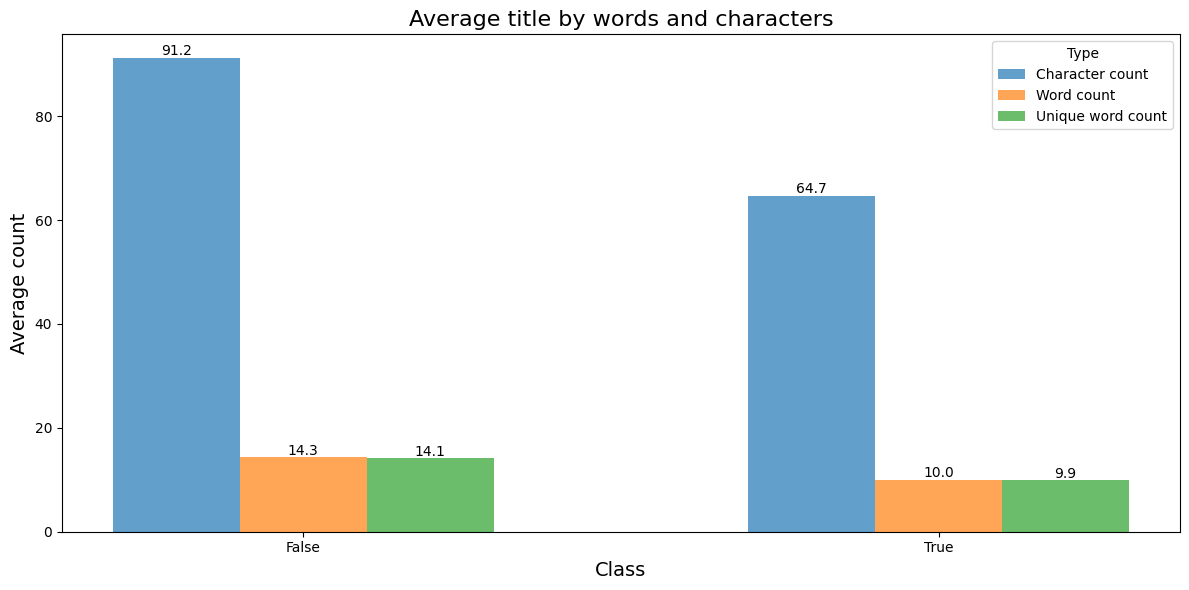

In [65]:
plt.figure(figsize=(12, 6))
labels = stats_per_class_title['label']
x = range(len(labels))
width = 0.2

bars_char = plt.bar(x, stats_per_class_title['title_char_count'], width, label='Character count', alpha=0.7)
bars_word = plt.bar([p + width for p in x], stats_per_class_title['title_word_count'], width, label='Word count', alpha=0.7)
bars_unique = plt.bar([p + 2 * width for p in x], stats_per_class_title['title_unique_word_count'], width, label='Unique word count', alpha=0.7)

for bars, stats in zip([bars_char, bars_word, bars_unique], ['title_char_count', 'title_word_count', 'title_unique_word_count']):
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f"{bar.get_height():.1f}", ha='center', fontsize=10)

plt.xticks([p + width for p in x], labels)
plt.title("Average title by words and characters", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Average count", fontsize=14)
plt.legend(title="Type")
plt.tight_layout()
plt.show()

Same finding in title statistics.

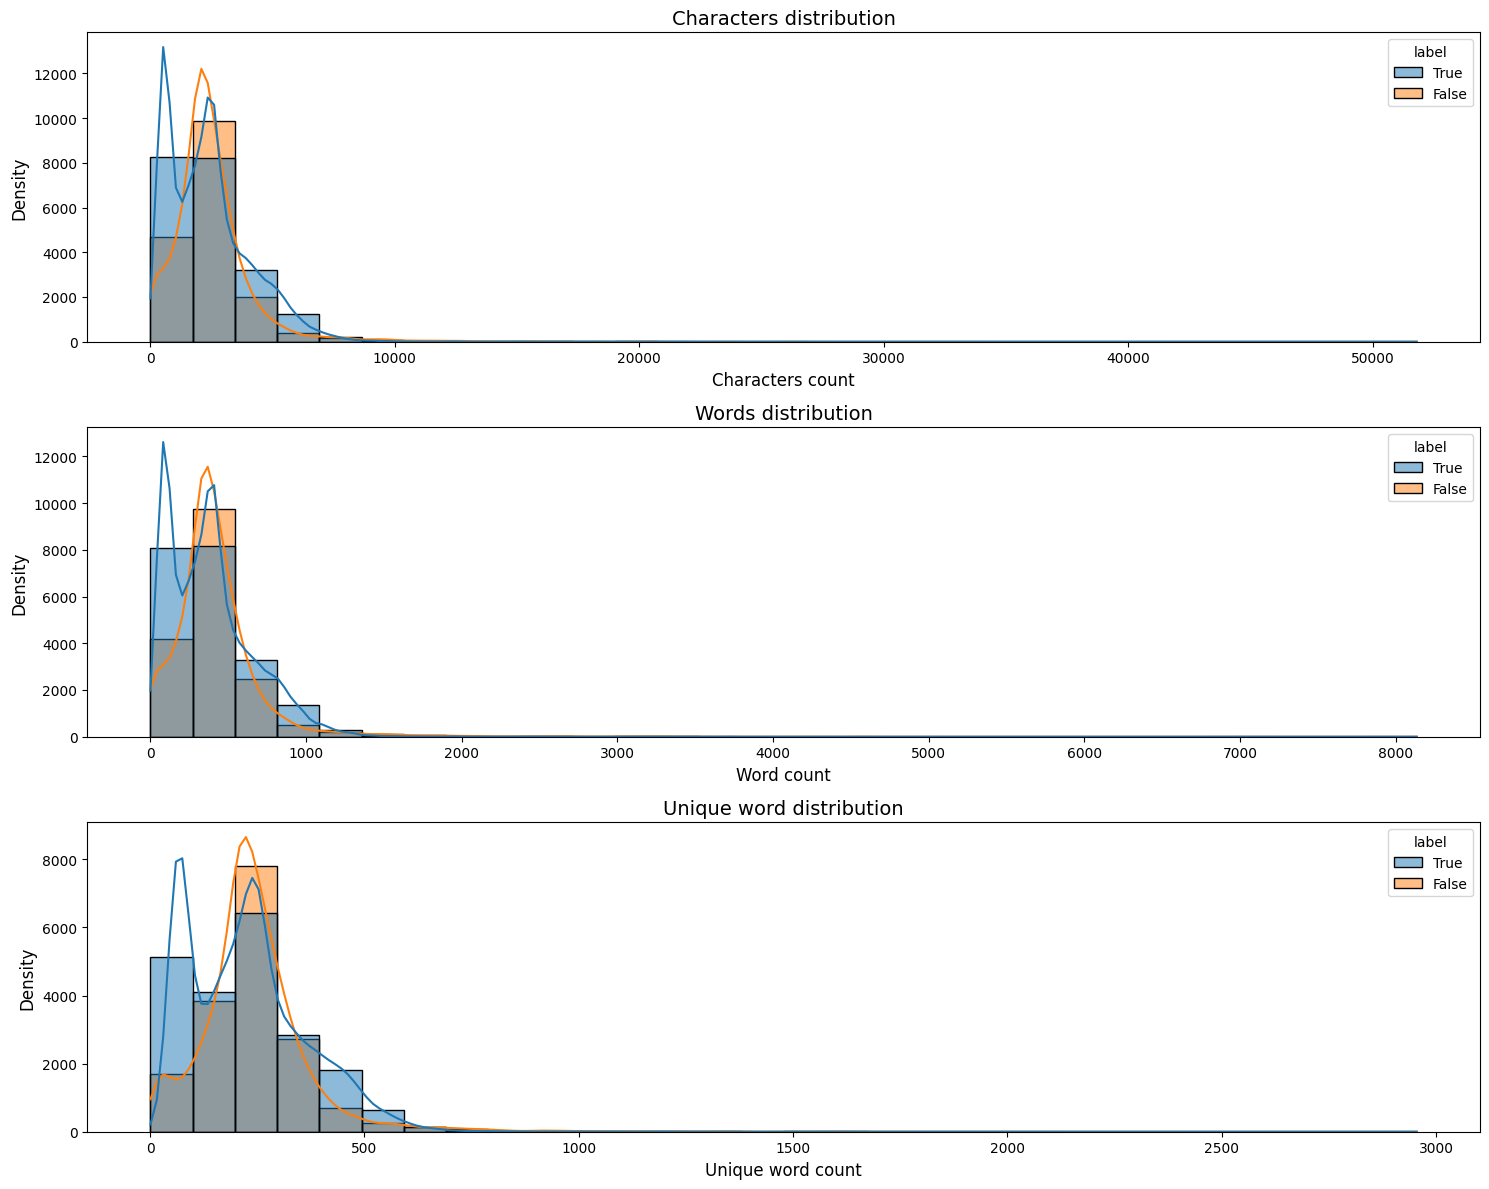

In [66]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
sns.histplot(data=combined_data, x='char_count', hue='label', kde=True, bins=30)
plt.title("Characters distribution", fontsize=14)
plt.xlabel("Characters count", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(3, 1, 2)
sns.histplot(data=combined_data, x='word_count', hue='label', kde=True, bins=30)
plt.title("Words distribution", fontsize=14)
plt.xlabel("Word count", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(3, 1, 3)
sns.histplot(data=combined_data, x='unique_word_count', hue='label', kde=True, bins=30)
plt.title("Unique word distribution", fontsize=14)
plt.xlabel("Unique word count", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()
plt.show()

Across all three metrics character count, word count and unique word count true articles are more concise while false are more diverse in their vocabulary.
The overlap between the distributions suggests that some false texts mimic the style of true articles which potentially make classification challenging.

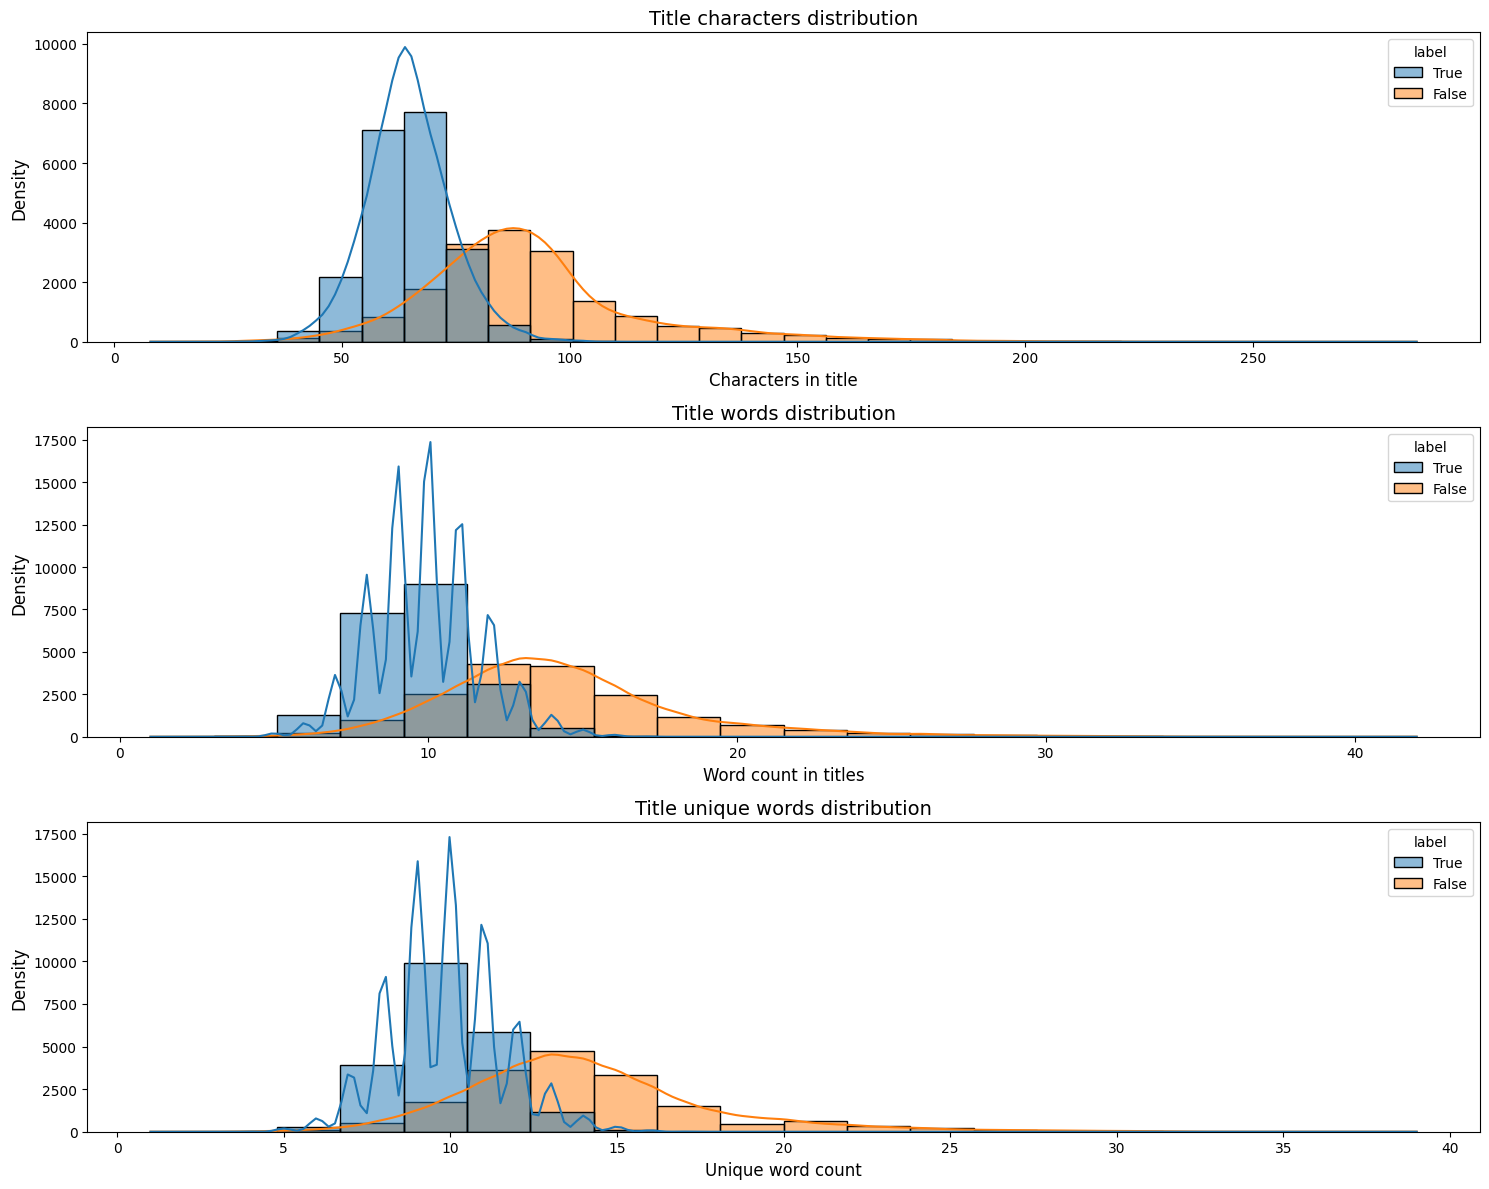

In [67]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
sns.histplot(data=combined_data, x='title_char_count', hue='label', kde=True, bins=30)
plt.title("Title characters distribution", fontsize=14)
plt.xlabel("Characters in title", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(3, 1, 2)
sns.histplot(data=combined_data, x='title_word_count', hue='label', kde=True, bins=20)
plt.title("Title words distribution", fontsize=14)
plt.xlabel("Word count in titles", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(3, 1, 3)
sns.histplot(data=combined_data, x='title_unique_word_count', hue='label', kde=True, bins=20)
plt.title("Title unique words distribution", fontsize=14)
plt.xlabel("Unique word count", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()
plt.show()

<ipython-input-68-6498028b377c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='label', y='word_count', palette='Set2')


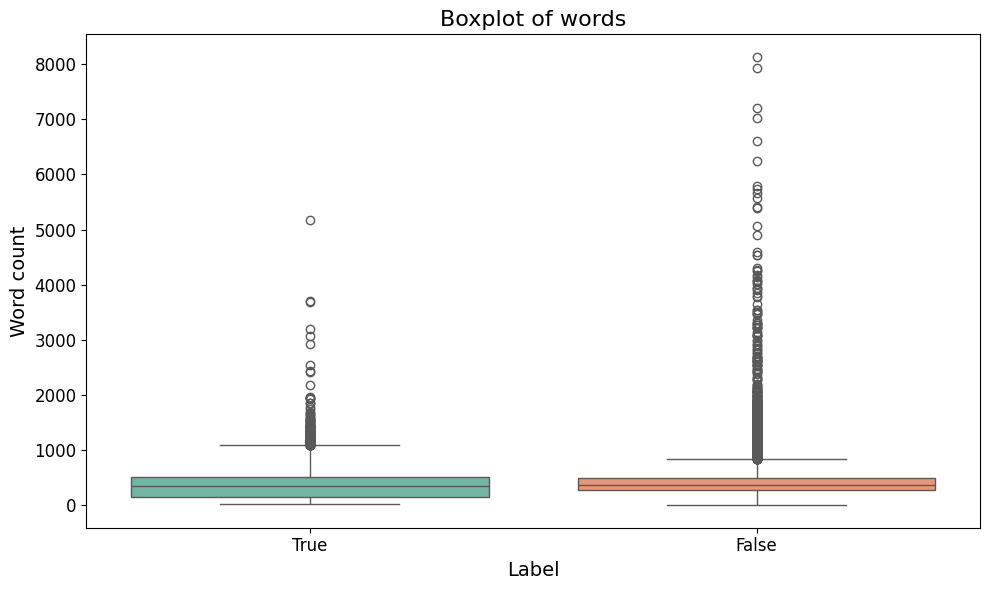

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='label', y='word_count', palette='Set2')

plt.title('Boxplot of words', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Word count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

We should look into word count outliers, do review of the text and underlying patterns.

Text(0.5, 0, 'Word count')

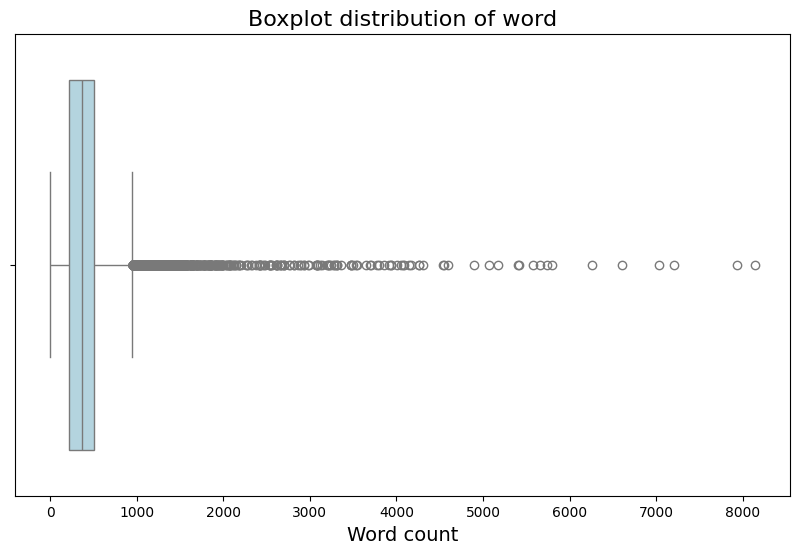

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_data['word_count'], color='lightblue')
plt.title('Boxplot distribution of word', fontsize=16)
plt.xlabel('Word count', fontsize=14)

In [70]:
Q1 = combined_data['word_count'].quantile(0.25)
Q3 = combined_data['word_count'].quantile(0.75)

In [71]:
IQR = Q3 - Q1

In [72]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [73]:
combined_data['is_outlier'] = combined_data['word_count'].apply(
    lambda x: 'Outlier' if (x < lower_bound or x > upper_bound) else 'Non-Outlier'
)

In [74]:
print(f"Outliers: {combined_data['is_outlier'].value_counts()}")

Outliers: is_outlier
Non-Outlier    37202
Outlier         1388
Name: count, dtype: int64


In [75]:
combined_data['question_mark_ratio'] = combined_data['text'].apply(lambda x: x.count('?')) / combined_data['word_count'].replace(0, 1)

In [76]:
combined_data['exclamation_mark_ratio'] = combined_data['text'].apply(lambda x: x.count('!')) / combined_data['word_count'].replace(0, 1)

In [77]:
combined_data['ellipses_ratio'] = combined_data['text'].apply(lambda x: x.count('...')) / combined_data['word_count'].replace(0, 1)

In [78]:
combined_data['url_count_ratio'] = combined_data['text'].apply(lambda x: (x.count('http') + x.count('www'))) / combined_data['word_count'].replace(0, 1)

In [79]:
combined_data['comma_ratio'] = combined_data['text'].apply(lambda x: x.count(',')) / combined_data['word_count'].replace(0, 1)

In [80]:
combined_data['period_ratio'] = combined_data['text'].apply(lambda x: x.count('.')) / combined_data['word_count'].replace(0, 1)

In [81]:
combined_data['capital_letter_ratio'] = combined_data['text'].apply(
    lambda x: sum(1 for char in x if char.isupper()) / len(x) if len(x) > 0 else 0
)

In [82]:
combined_data['special_char_ratio'] = combined_data['text'].apply(
    lambda x: sum(1 for char in x if not char.isalnum() and not char.isspace()) / len(x) if len(x) > 0 else 0
)

In [83]:
features = [
    'question_mark_ratio',
    'exclamation_mark_ratio',
    'ellipses_ratio',
    'url_count_ratio',
    'comma_ratio',
    'period_ratio',
    'capital_letter_ratio',
    'special_char_ratio'
]

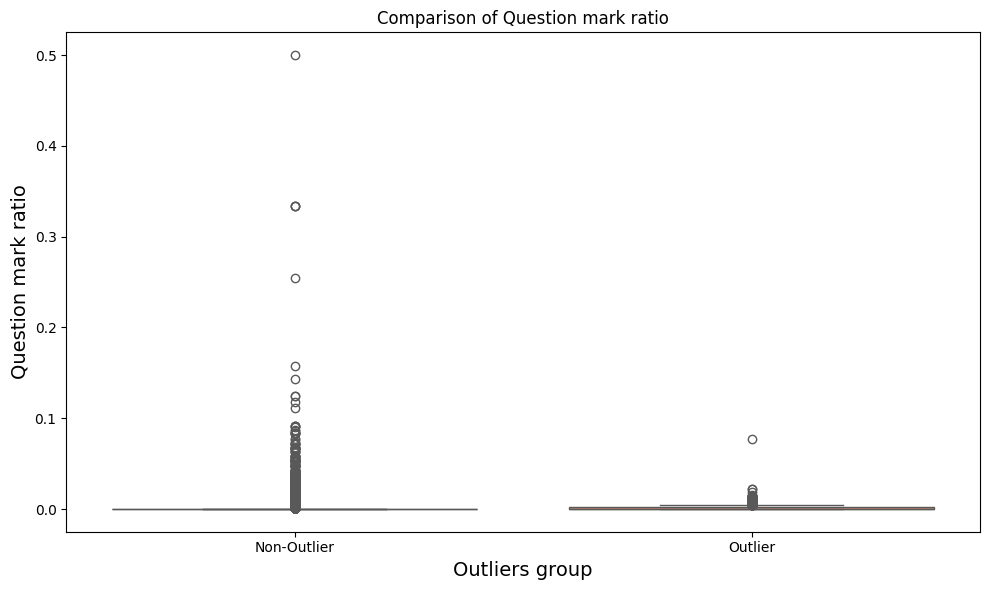

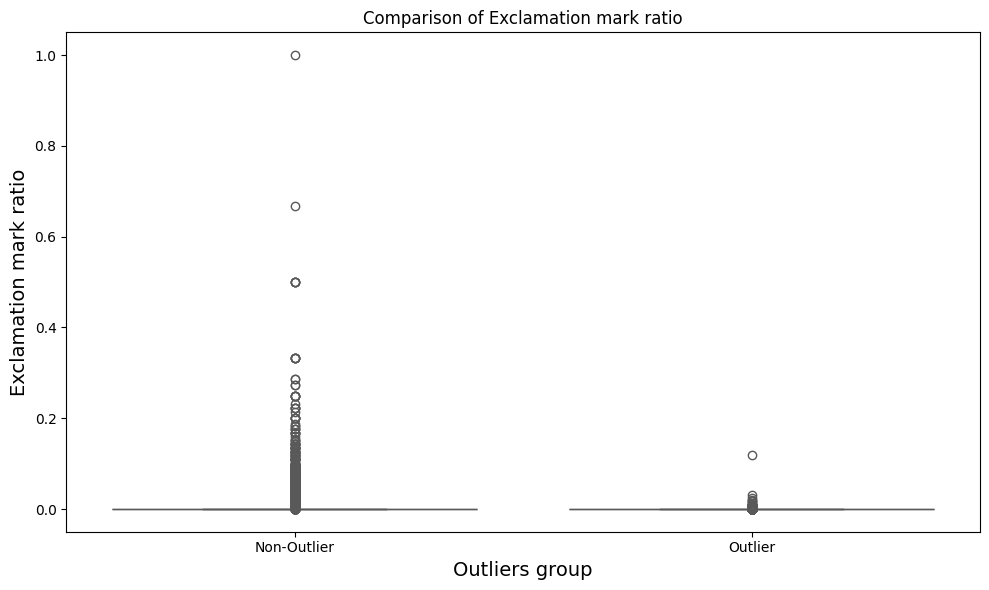

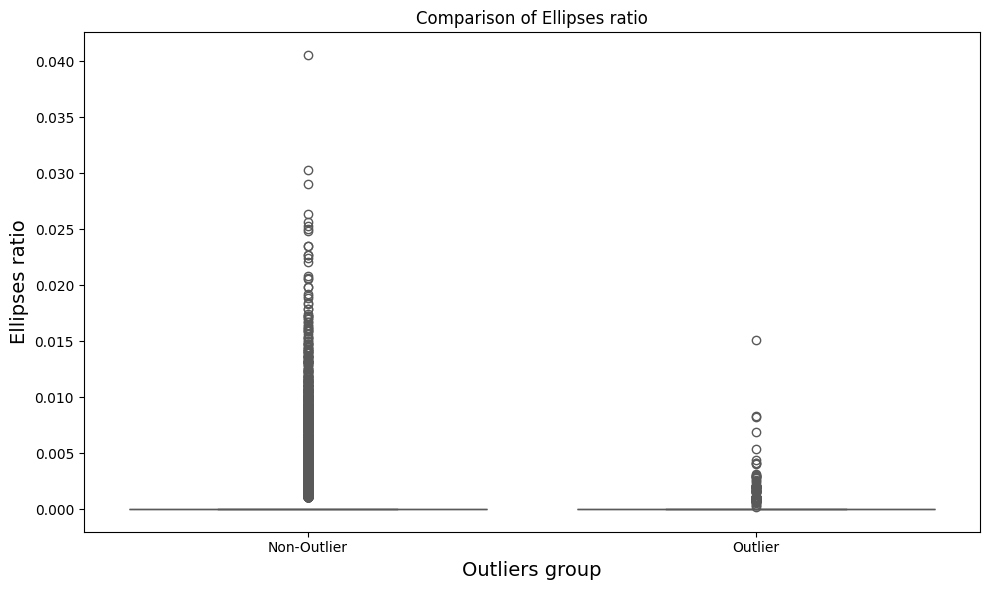

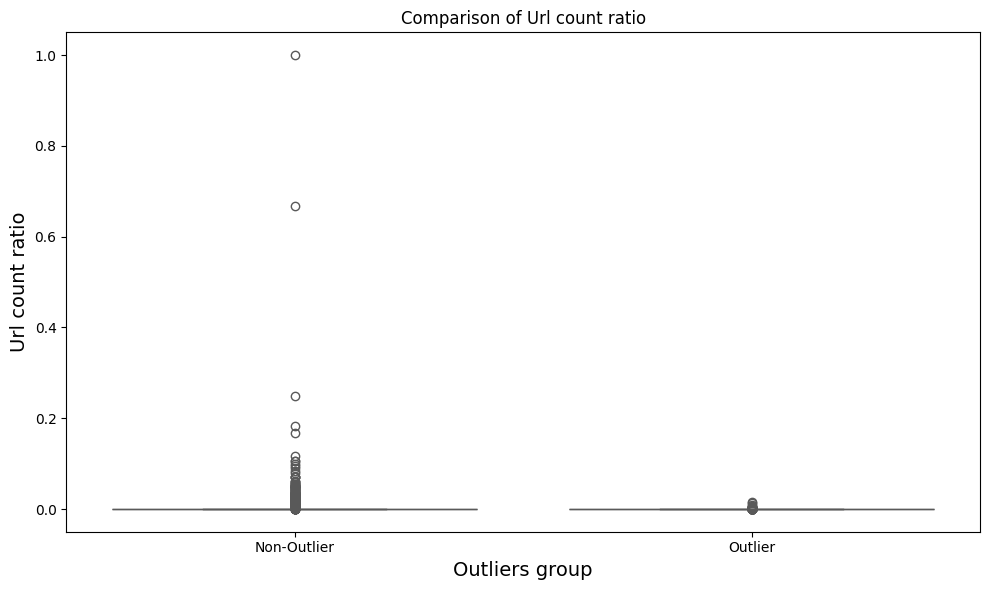

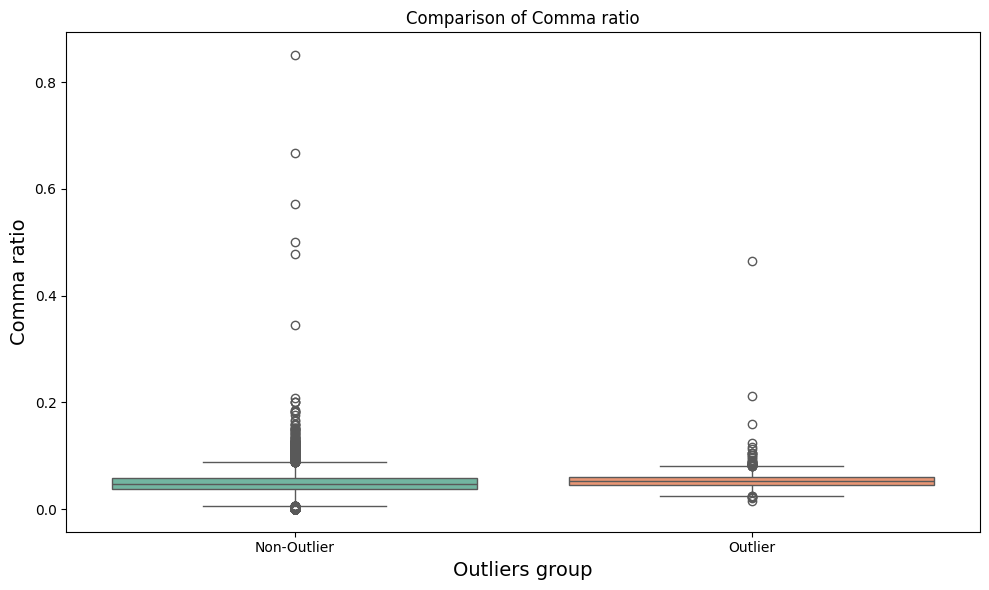

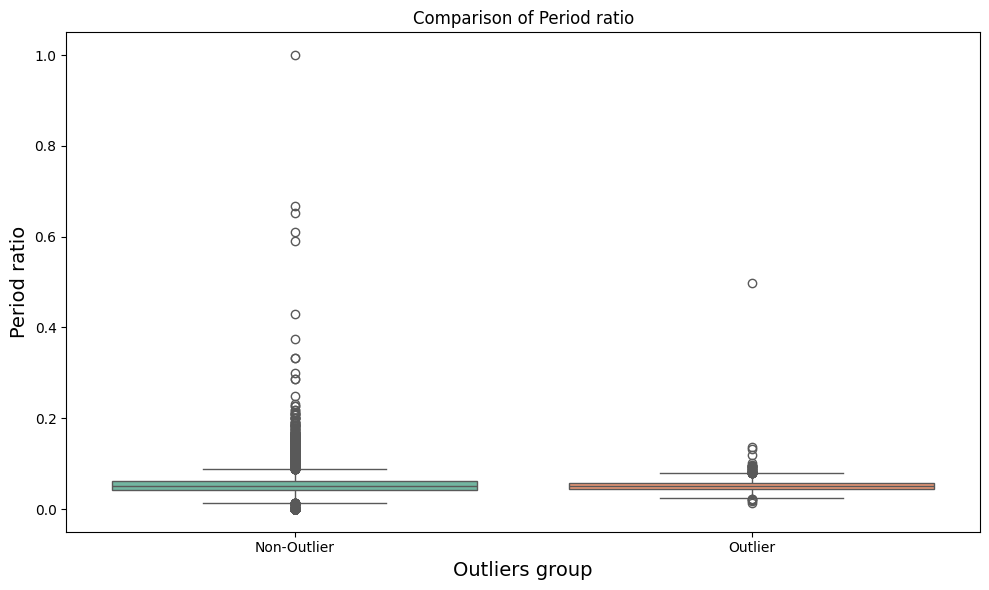

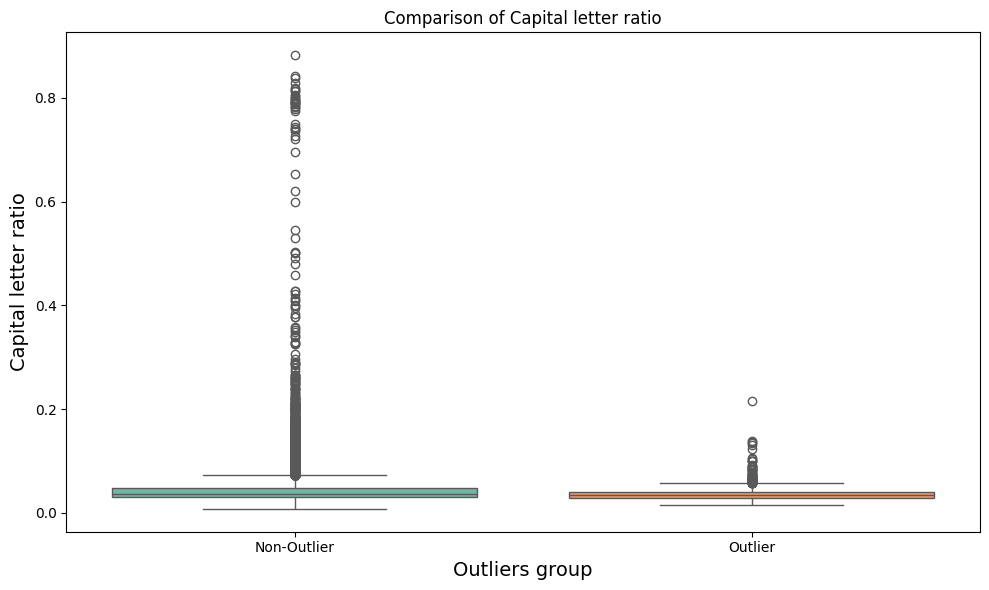

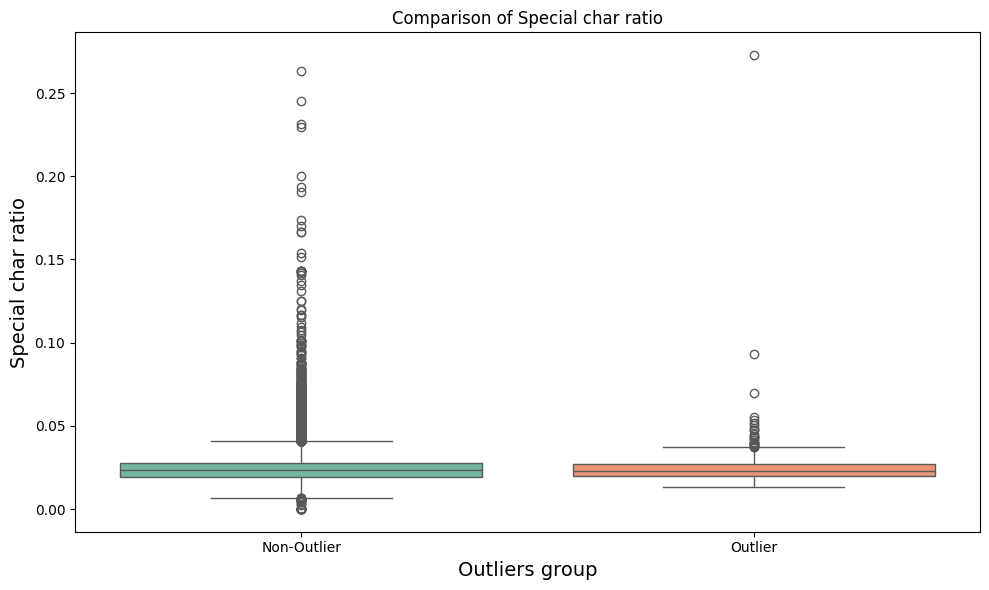

In [84]:
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_data, x='is_outlier', y=feature, hue='is_outlier', palette='Set2', legend=False)
    plt.title(f"Comparison of {feature.replace('_', ' ').capitalize()}")
    plt.xlabel("Outliers group", fontsize=14)
    plt.ylabel(f"{feature.replace('_', ' ').capitalize()}", fontsize=14)
    plt.tight_layout()
    plt.show()


This what we could have done to understand outlying long text, there doesn't seem to be any indication based on the derived features that they are false text that could potentially be noise. Let's have random look at some.

In [85]:
outliers = combined_data[combined_data['is_outlier'] == 'Outlier']

In [86]:
sample_outliers = outliers.sample(n=10, random_state=42)

In [87]:
for idx, row in sample_outliers.iterrows():
    print(f"--- Outlier {idx} ---")
    print(f"Title: {row['title']}")
    print(f"Text: {row['text'][:500]}...")
    print(f"Word count: {row['word_count']}")
    print(f"Special character ratio: {row['special_char_ratio']:.2f}")
    print(f"URL count ratio: {row['url_count_ratio']:.2f}")
    print(f"Capital letter ratio: {row['capital_letter_ratio']:.2f}")

--- Outlier 17972 ---
Title: Rainbow raids: Egypt launches its widest anti-gay crackdown yet
Text: CAIRO (Reuters) - Sarah Hegazy has been jailed, beaten by inmates, and could face a life sentence in an Egyptian prison if found guilty of  promoting sexual deviancy  and other charges tied to her alleged crime: waving a rainbow flag at a concert. The 28-year-old denies waving the flag but is one of 57 people arrested so far in Egypt s widest anti-gay crackdown yet, a swift zero-tolerance response to a rare show of public support for lesbian, gay, bisexual and transgender (LGBT) rights in the co...
Word count: 1280
Special character ratio: 0.02
URL count ratio: 0.00
Capital letter ratio: 0.02
--- Outlier 6036 ---
Title: Factbox: Dakota Access Pipeline's long journey
Text: (Reuters) - U.S. President Donald Trump signed an executive order on Tuesday allowing the Dakota Access Pipeline to go forward, after months of protests from Native American groups and climate activists pushed the Obama 

Nothing particulary unusual about these texts.

In [88]:
combined_data = combined_data.drop(columns=['is_outlier'])

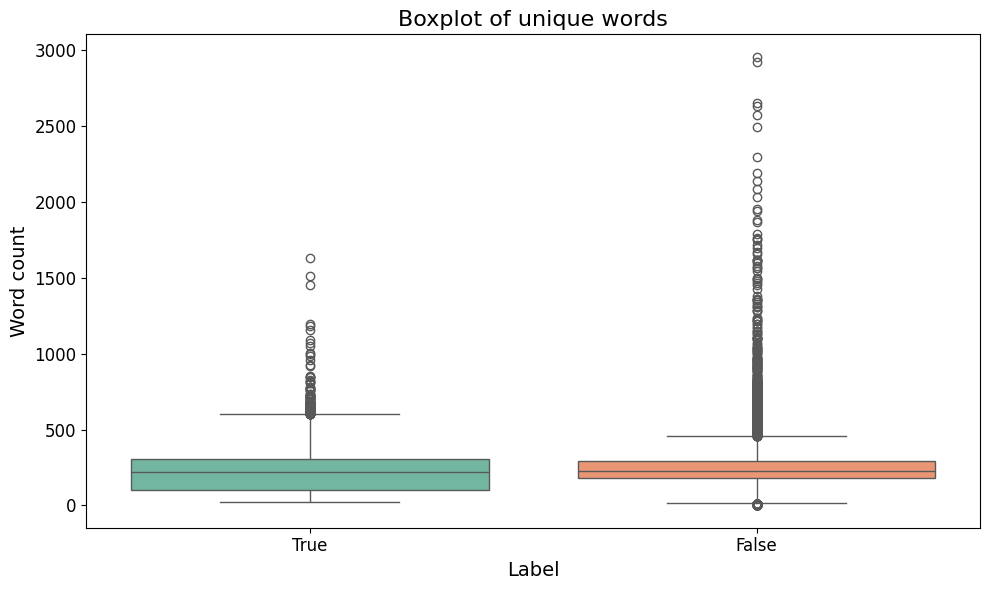

In [89]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='label', y='unique_word_count', hue='label', palette='Set2', legend=False)
plt.title('Boxplot of unique words', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Word count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

We can see some outliers below the lower bound and that is interesting these potentially can be incorrect or text or some text that will only introduce unnecessary noice to the model.

In [90]:
false_data = combined_data[combined_data['label'] == 'False']

In [91]:
Q1 = false_data['unique_word_count'].quantile(0.25)
Q3 = false_data['unique_word_count'].quantile(0.75)
IQR = Q3 - Q1

In [92]:
lower_bound = Q1 - 1.5 * IQR

In [93]:
false_outliers = false_data[false_data['unique_word_count'] < lower_bound]

print(f"Lower bound for unique words count: {lower_bound}")
print(f"Number of outliers: {len(false_outliers)}")

Lower bound for unique words count: 12.5
Number of outliers: 155


In [94]:
display(false_outliers)

title  \
32324  MY FAVORITE EXCUSES…Featuring Hillary Rotten C...   
32438  JUDGE JEANINE’S OPENING STATEMENT: “Our Presid...   
32506  HYSTERICAL! HERE’S WHY TRUMP SAID TO REPORTER:...   
32558  HYSTERICAL! RAND PAUL FIRES BACK AT JOHN MCCAI...   
32572  RACHEL MADDOW Announces Plan To Reveal Trump’s...   
...                                                  ...   
41217  9 FACTS ABOUT SLAVERY Democrats Don’t Want You...   
41803  ONLY IN DETROIT: Entitled Squatter Gets Squatt...   
42096  WOW! BRAVE VETERAN CONFRONTS FERGUSON THUGS ST...   
42237  (Video) Obama Supporters Sign Petition to NUKE...   
42251  [Video] AWESOME: TEXAS MOM FRUSTRATED BY MCKIN...   

                                                    text    subject  \
32324                                             Enjoy:   politics   
32438  Watch my #OpeningStatment   pic.twitter.com/Qp...   politics   
32506                                       Read more:WT   politics   
32558  HERE S WHAT MCCAIN SAID THAT GOT RAND PAUL ALL...   politics   
32572     Maddow has a freak out at the 48 second mark:    politics   
...                                                  ...        ...   
41217                            SPREAD this EVERYWHERE!  left-news   
41803                   When karma bites ya  in the a*s   left-news   
42096                  My brothers DIED for that flag!    left-news   
42237  These people will support just about anything ...  left-news   
42251  Here s a mom who knows how to raise her children   left-news   

               date  label                                       cleaned_text  \
32324  Apr 17, 2017  False                                              enjoy   
32438   Apr 1, 2017  False  watch my openingstatment pic twitter com qpkzw...   
32506  Mar 23, 2017  False                                       read more wt   
32558  Mar 16, 2017  False  here s what mccain said that got rand paul all...   
32572  Mar 14, 2017  False          maddow has a freak out at the second mark   
...             ...    ...                                                ...   
41217   May 5, 2016  False                             spread this everywhere   
41803  Dec 18, 2015  False                     when karma bites ya in the a s   
42096  Aug 12, 2015  False                     my brothers died for that flag   
42237  Jun 15, 2015  False  these people will support just about anything ...   
42251  Jun 11, 2015  False   here s a mom who knows how to raise her children   

                                           cleaned_title  \
32324  my favorite excuses featuring hillary rotten c...   
32438  judge jeanine s opening statement our presiden...   
32506  hysterical here s why trump said to reporter i...   
32558  hysterical rand paul fires back at john mccain...   
32572  rachel maddow announces plan to reveal trump s...   
...                                                  ...   
41217  facts about slavery democrats don t want you t...   
41803  only in detroit entitled squatter gets squatte...   
42096  wow brave veteran confronts ferguson thugs sto...   
42237  video obama supporters sign petition to nuke c...   
42251  video awesome texas mom frustrated by mckinney...   

                           cleaned_and_without_stop_text  \
32324                                              enjoy   
32438  watch openingstatment pic twitter com qpkzw eh...   
32506                                            read wt   
32558                   mccain said got rand paul worked   
32572                           maddow freak second mark   
...                                                  ...   
41217                                  spread everywhere   
41803                                     karma bites ya   
42096                                 brothers died flag   
42237     people support anything obama says scary stuff   
42251                           mom knows raise children   

                          cleaned_and_without_stop_title  char

From the sample above we can see that cleaned texts are quite short, some only have 1 unique word. We will consider removing this data as it might skew the model.

In [95]:
combined_data = combined_data[
    ~((combined_data['label'] == 'False') & (combined_data['unique_word_count'] < lower_bound))
]

print(f"Dataset size: {len(combined_data)}")

Dataset size: 38435


In [96]:
def get_top_words(text_data, top_n=10):
    all_words = " ".join(text_data).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

In [97]:
true_words = get_top_words(combined_data[combined_data['label'] == "True"]['cleaned_and_without_stop_text'])
false_words = get_top_words(combined_data[combined_data['label'] == "False"]['cleaned_and_without_stop_text'])

In [98]:
true_df = pd.DataFrame(true_words, columns=['Word', 'Count'])
false_df = pd.DataFrame(false_words, columns=['Word', 'Count'])

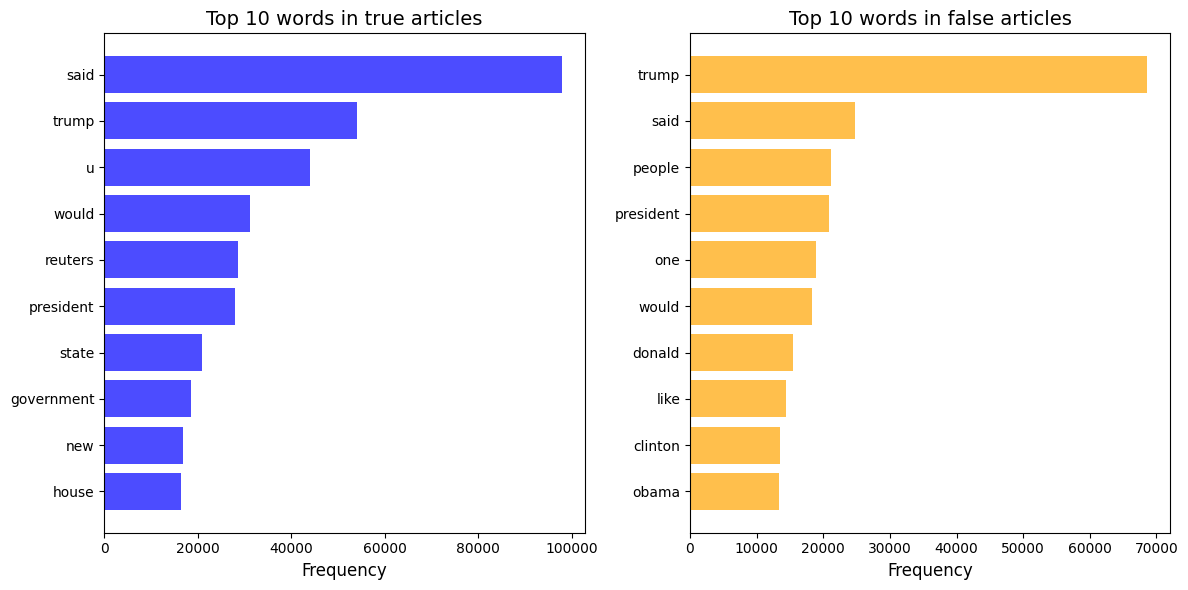

In [99]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(true_df['Word'], true_df['Count'], color='blue', alpha=0.7)
plt.title("Top 10 words in true articles", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(false_df['Word'], false_df['Count'], color='orange', alpha=0.7)
plt.title("Top 10 words in false articles", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

We can see some clear differences when it comes to true and false articles. False articles are dominated by word trump, this person is mentioned 70000 times in the those articles while true articles less than 60000. Also we can see that it in false other political figures are in top 10 most appeared words. Also we can see that people is very commonly used like we saw from word cloud. In true articles we can see mentions or source, a lot ot articles are from reuters and we have noticed in sample view that in some that is mentioned at the begging of the article.

In [100]:
true_title_words = get_top_words(combined_data[combined_data['label'] == "True"]['cleaned_and_without_stop_title'])
false_title_words = get_top_words(combined_data[combined_data['label'] == "False"]['cleaned_and_without_stop_title'])

In [101]:
true_title_df = pd.DataFrame(true_title_words, columns=['Word', 'Count'])
false_title_df = pd.DataFrame(false_title_words, columns=['Word', 'Count'])

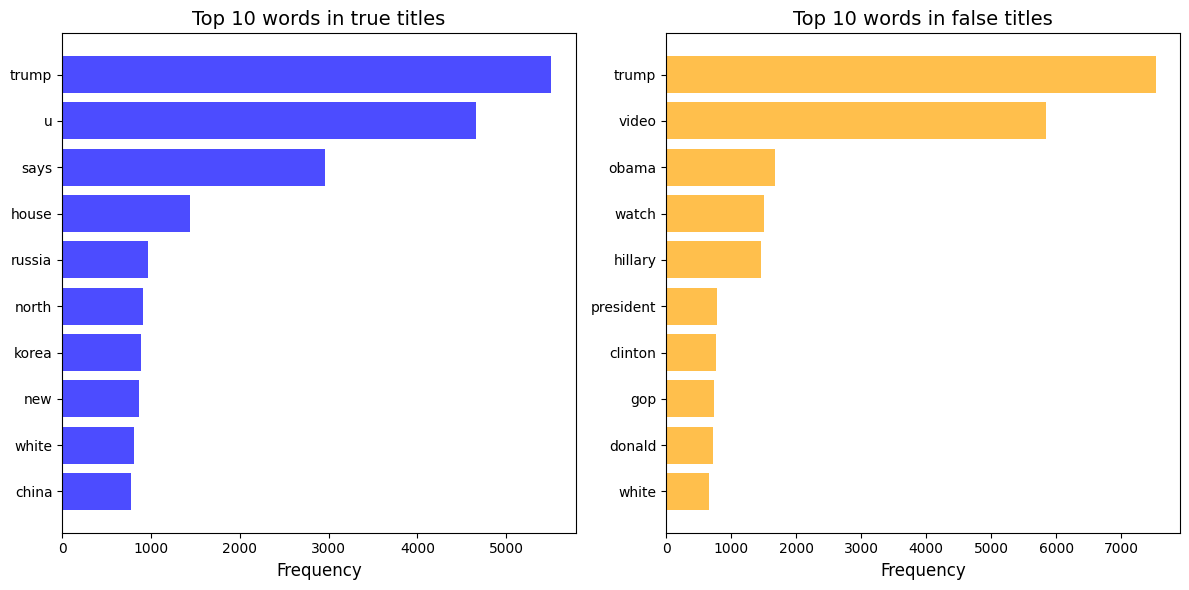

In [102]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(true_title_df['Word'], true_title_df['Count'], color='blue', alpha=0.7)
plt.title("Top 10 words in true titles", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(false_title_df['Word'], false_title_df['Count'], color='orange', alpha=0.7)
plt.title("Top 10 words in false titles", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

 The difference in word choices like "breaking" in false and "says" in true suggests that titles alone might be a strong feature for distinguishing between true and false articles. Often in the true text titles we can see countries mentioned meanwhile in false othe political figures.

In [103]:
def get_top_ngrams(text_data, n=2, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_matrix = vectorizer.fit_transform(text_data)
    ngram_counts = ngram_matrix.sum(axis=0).tolist()[0]
    ngram_vocab = vectorizer.get_feature_names_out()
    ngram_freq = sorted(zip(ngram_vocab, ngram_counts), key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Count'])

In [104]:
true_ngrams = get_top_ngrams(combined_data[combined_data['label'] == "True"]['cleaned_and_without_stop_text'], n=2)
false_ngrams = get_top_ngrams(combined_data[combined_data['label'] == "False"]['cleaned_and_without_stop_text'], n=2)

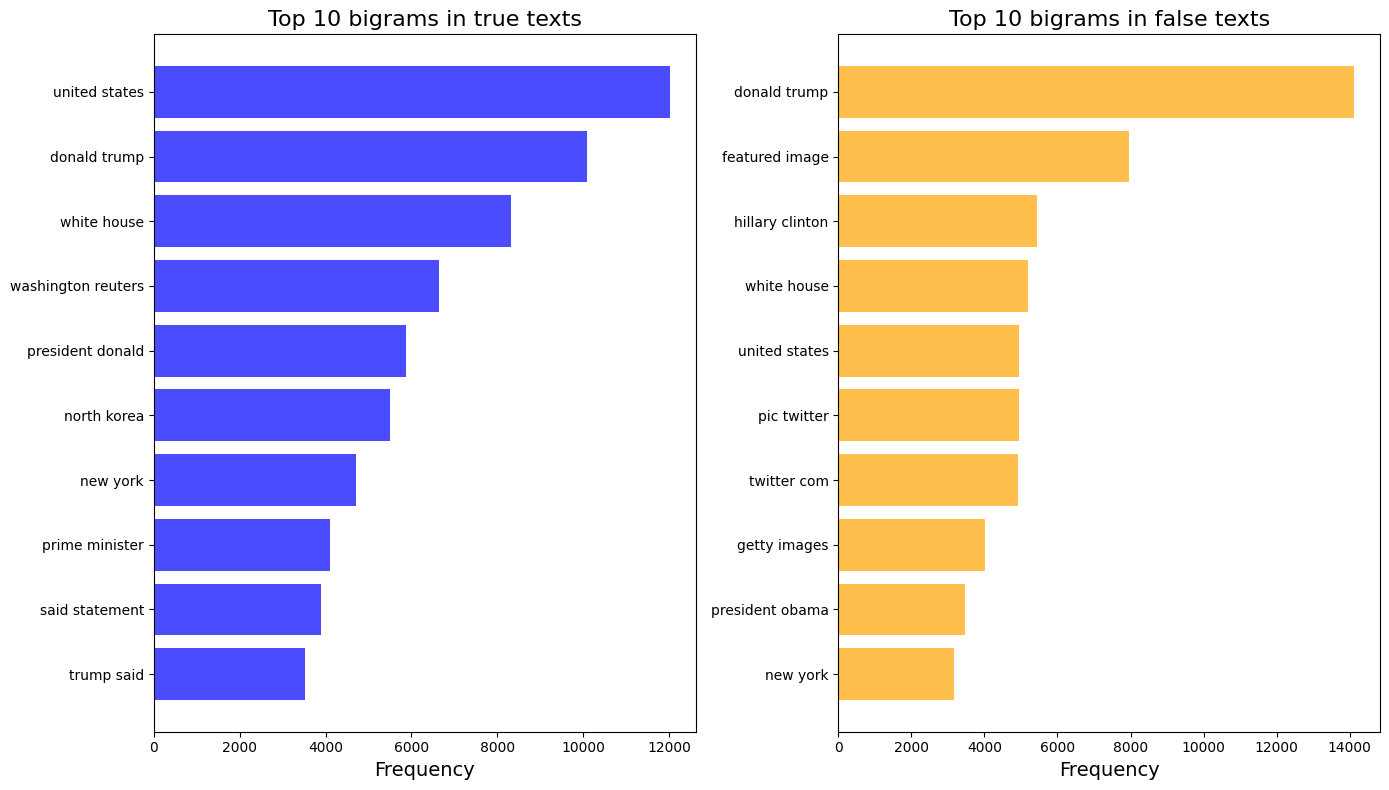

In [105]:
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.barh(true_ngrams['N-gram'], true_ngrams['Count'], color='blue', alpha=0.7)
plt.title("Top 10 bigrams in true texts", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(false_ngrams['N-gram'], false_ngrams['Count'], color='orange', alpha=0.7)
plt.title("Top 10 bigrams in false texts", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In 2-gram plots above we can see that in both cases articles are around president donal trump. In false text it is most common combination in true text second most common. Interesting that we can see true text washington reuters mentioned offenly and in false twitter com. From even bigram we can see how we can associate truthfull text with reliable source.

In [106]:
true_title_ngrams = get_top_ngrams(combined_data[combined_data['label'] == "True"]['cleaned_and_without_stop_title'], n=2)
false_title_ngrams = get_top_ngrams(combined_data[combined_data['label'] == "False"]['cleaned_and_without_stop_title'], n=2)

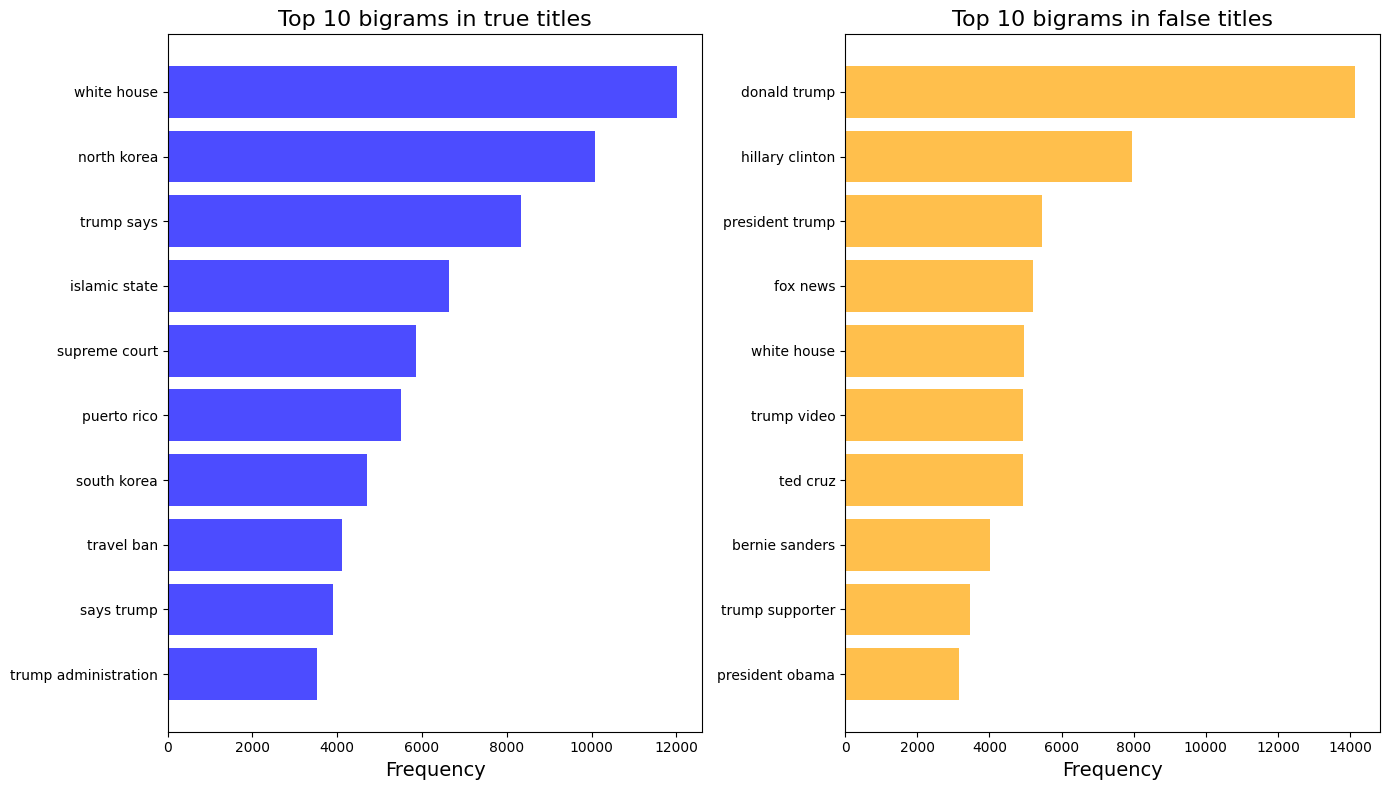

In [107]:
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.barh(true_title_ngrams['N-gram'], true_ngrams['Count'], color='blue', alpha=0.7)
plt.title("Top 10 bigrams in true titles", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(false_title_ngrams['N-gram'], false_ngrams['Count'], color='orange', alpha=0.7)
plt.title("Top 10 bigrams in false titles", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In truthfull articles titles we can see there is a lot of mentioning of other countries like south or north korea, puerto rico, since text are political geopolitical information is expected to appear, meanwhile in false titles we can see more changes from twitter to fox news and mentions of other political figures like bernie sanders and ted cruz.

**TF-IDF**

In [108]:
tfidf = TfidfVectorizer(max_features=500)

In [109]:
tfidf_matrix = tfidf.fit_transform(combined_data['cleaned_and_without_stop_text'])

In [110]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['label'] = combined_data['label'].values

In [111]:
true_tfidf = tfidf_df[tfidf_df['label'] == "True"].drop(columns=['label']).mean().sort_values(ascending=False).head(20)
false_tfidf = tfidf_df[tfidf_df['label'] == "False"].drop(columns=['label']).mean().sort_values(ascending=False).head(20)

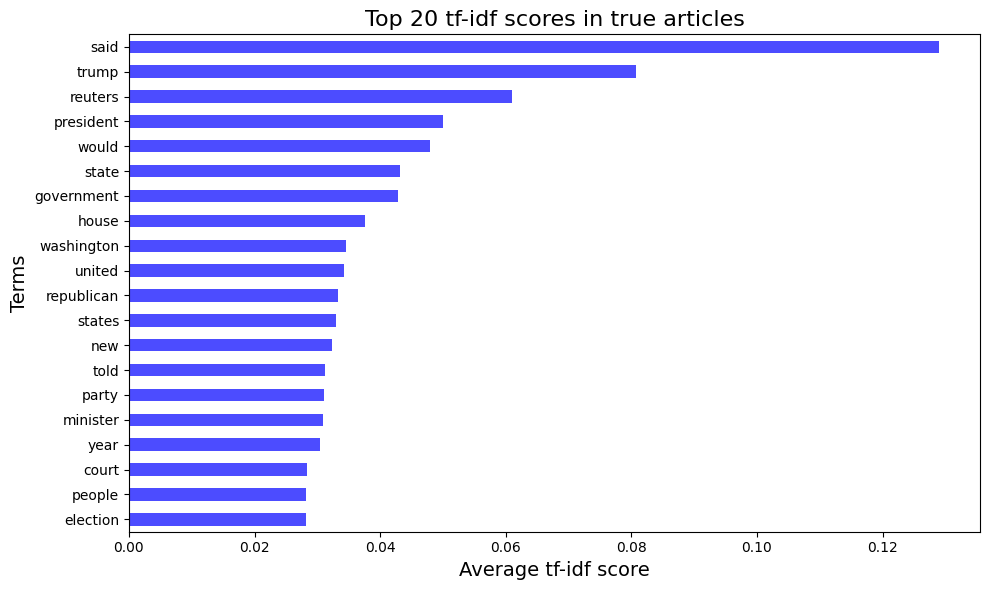

In [112]:
plt.figure(figsize=(10, 6))
true_tfidf.sort_values().plot(kind='barh', color='blue', alpha=0.7)
plt.title("Top 20 tf-idf scores in true articles", fontsize=16)
plt.xlabel("Average tf-idf score", fontsize=14)
plt.ylabel("Terms", fontsize=14)
plt.tight_layout()
plt.show()

In true articles word said is the most distinguishing word along trump and reuters, which was suspected. We can see a lot of goverment bodies mentioned and for people is in top 20 list which is surprising given that we saw how often it was mentioned in false articles.

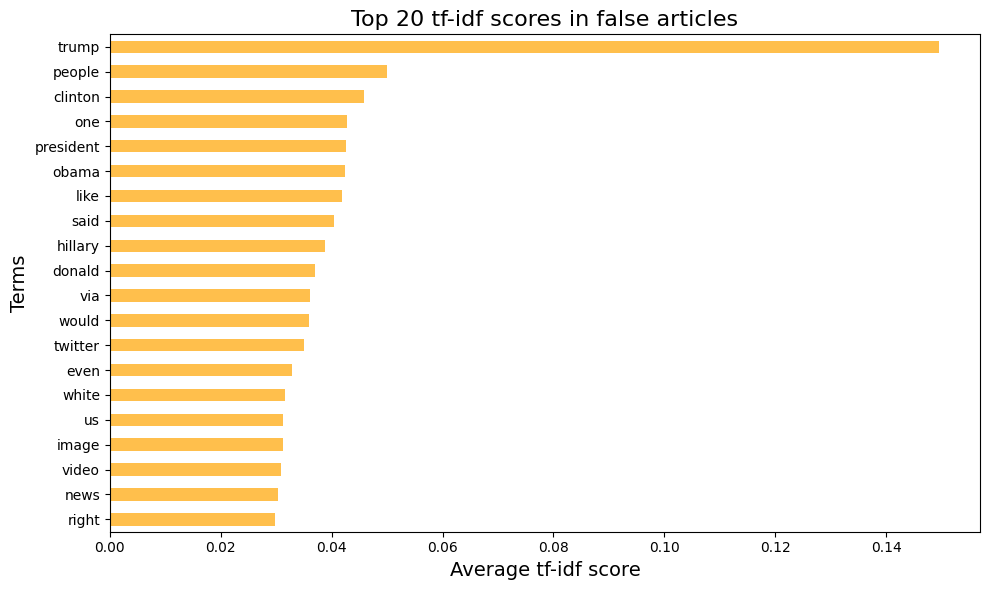

In [113]:
plt.figure(figsize=(10, 6))
false_tfidf.sort_values().plot(kind='barh', color='orange', alpha=0.7)
plt.title("Top 20 tf-idf scores in false articles", fontsize=16)
plt.xlabel("Average tf-idf score", fontsize=14)
plt.ylabel("Terms", fontsize=14)
plt.tight_layout()
plt.show()

words trump and people are most distinguishing words in false articles even though we had trump every high on true articles as well. Here instead of reuters we can see twitter, image and video these do not appear in tru articles tf-idf top 20 scors. We can see often mentioned political rivals clinton, hilary, obama as well. They do not appear in true articles tf-idf top 20 list.
We can assume that tf-idf encoding based on unmasked texts could very easily distuingish betweeen true and false articles.

**Statistics**

In [114]:
def calculate_word_lengths(text):
    return [len(word) for word in text.split()]

In [115]:
combined_data['cleaned_word_lengths'] = combined_data['cleaned_and_without_stop_text'].apply(calculate_word_lengths)

In [116]:
word_lengths_flat = [
    {'Word Length': length, 'Label': label}
    for label, lengths in zip(combined_data['label'], combined_data['cleaned_word_lengths'])
    for length in lengths
]

In [117]:
word_lengths_df = pd.DataFrame(word_lengths_flat)

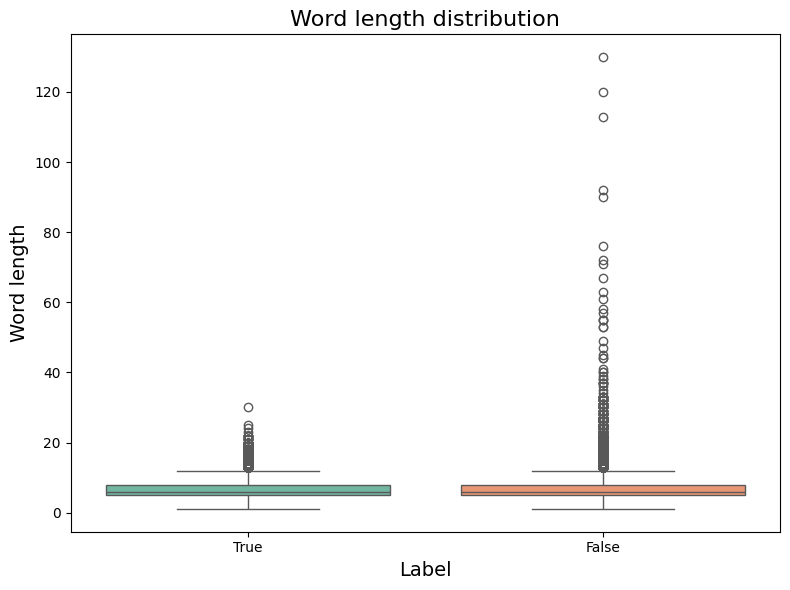

In [118]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=word_lengths_df, x='Label', y='Word Length', hue='Label', palette='Set2', legend=False)
plt.title("Word length distribution", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Word length", fontsize=14)
plt.tight_layout()
plt.show()

The medians are relatively similar for both "True" and "False" labels, indicating comparable average word lengths after cleaning.
This suggests that basic word lengths don't drastically differ between the two labels even after stopword removal and symbols, urls and numerbers cleaning.
Both true and false labels have a narrow IQR indicating that the majority of words are short between 3-8 characters.

**Outliers:**

There are significant outliers in both categories but false texts having more extreme outliers with word lengths exceeding 100 characters.These outliers may represent anomalous words.

In [119]:
outlier_threshold = 30

In [120]:
true_cleaned_long_words = [
    word for lengths, text in zip(combined_data[combined_data['label'] == "True"]['cleaned_word_lengths'],
                                  combined_data[combined_data['label'] == "True"]['cleaned_and_without_stop_text'])
    for word in text.split() if len(word) > outlier_threshold
]

In [121]:
false_cleaned_long_words = [
    word for lengths, text in zip(combined_data[combined_data['label'] == "False"]['cleaned_word_lengths'],
                                  combined_data[combined_data['label'] == "False"]['cleaned_and_without_stop_text'])
    for word in text.split() if len(word) > outlier_threshold
]

In [122]:
true_cleaned_long_words_df = pd.DataFrame({'Label': 'True', 'Long Word': list(set(true_cleaned_long_words))})
false_cleaned_long_words_df = pd.DataFrame({'Label': 'False', 'Long Word': list(set(false_cleaned_long_words))})

In [123]:
cleaned_long_words_combined_df = pd.concat([true_cleaned_long_words_df, false_cleaned_long_words_df], ignore_index=True)

In [124]:
print(len(cleaned_long_words_combined_df))

54


In [125]:
print(cleaned_long_words_combined_df.head(30))

    Label                                          Long Word
0   False  hahahahahahahahahahahahahahahahahaahahahahahah...
1   False      lmaoooooooooooooooooooooooooooooooooooooooooo
2   False                 twittertwittertwitterinterestingly
3   False  twittertwittertwittertwittertwittertwitterwhoever
4   False            twittertwittertwittertwittertwitterthis
5   False  twittertwittertwittertwittertwittertwittertwit...
6   False  twittertwittertwittertwittertwittertwittertwit...
7   False           attacklowratedcabletvmorningshowhostsday
8   False             twittertwittertwittertwittertwitterand
9   False                    twittertwittertwittertwitteryou
10  False  twittertwittertwittertwittertwittertwittertwit...
11  False                  donaldtrumpwantstobanghisdaughter
12  False                  creepyoldpresidentmakingupbattles
13  False  twittertwittertwittertwittertwittertwittertwit...
14  False  twittertwittertwittertwittertwittertwittertwit...
15  False              t

We can see that some false text have very long some nonesensical words. Some are emotions expresions, most of them are combinations of twitter words. We will delete these from the set.

In [126]:
def has_outlier_word(word_lengths, threshold=outlier_threshold):
    return any(length > threshold for length in word_lengths)

In [127]:
combined_data = combined_data[~combined_data['cleaned_word_lengths'].apply(lambda x: has_outlier_word(x))].copy()

In [128]:
print(f"Dataset size: {len(combined_data)}")

Dataset size: 38388


**Titles word length distribution**

In [129]:
combined_data['cleaned_title_word_lengths'] = combined_data['cleaned_and_without_stop_title'].apply(calculate_word_lengths)

In [130]:
word_lengths_flat = [
    {'Word length': length, 'Label': label}
    for label, lengths in zip(combined_data['label'], combined_data['cleaned_title_word_lengths'])
    for length in lengths
]

In [131]:
word_lengths_df = pd.DataFrame(word_lengths_flat)

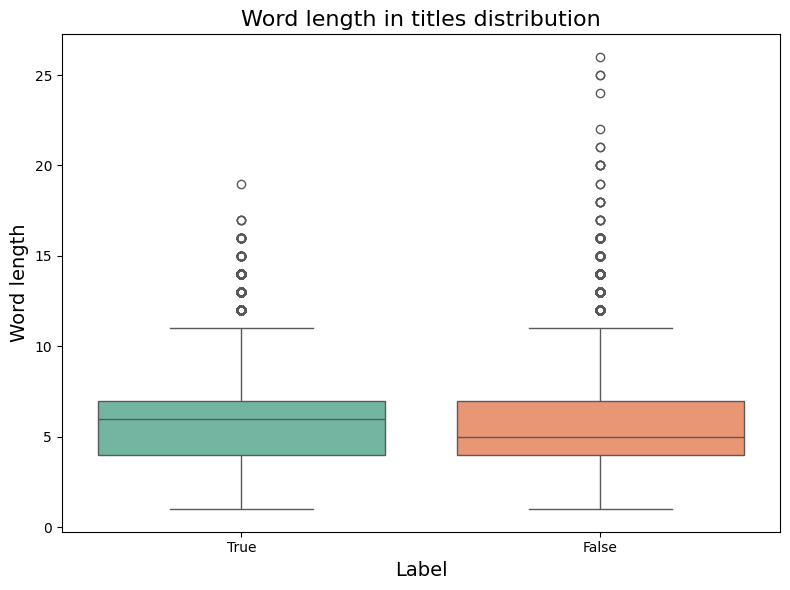

In [132]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=word_lengths_df, x='Label', y='Word length', hue='Label', palette='Set2', dodge=False)
plt.title("Word length in titles distribution", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Word length", fontsize=14)
plt.tight_layout()
plt.show()

Here we can see distributions are much more alike, with few more and lenghier outliers in false text titles.

We will check how average word length in texts and how each label distributed when it comes to this text feature.

In [133]:
combined_data['avg_word_length'] = combined_data['text'].apply(calculate_avg_word_length)

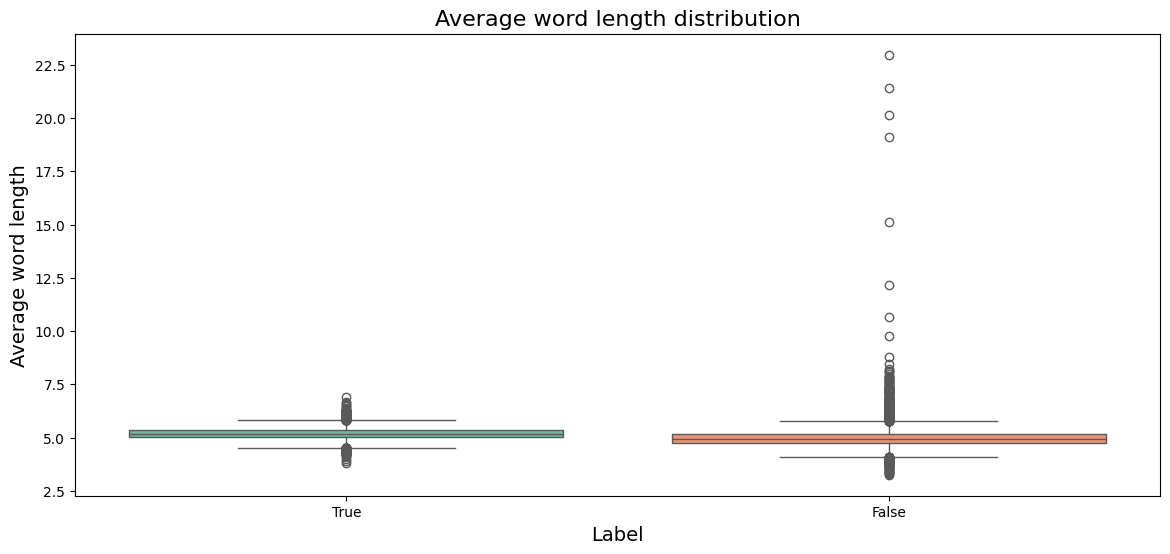

In [134]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='label', y='avg_word_length', palette='Set2', hue='label')
plt.title("Average word length distribution", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Average word length", fontsize=14)
plt.show()

In [135]:
average_word_length_threshold = 10

In [136]:
outlier_texts = combined_data[combined_data['avg_word_length'] > average_word_length_threshold]

In [137]:
outlier_texts_disp = outlier_texts.head(10)

In [138]:
for _, row in outlier_texts_disp.iterrows():
    print(f"Text: {row['text']}")
    print(f"Average word length: {row['avg_word_length']:.2f}")
    print("----")

Text: I ve been saying for a long time now that the Republican Party was on the verge of splitting   and I was right. Sort of. I always assumed that the establishment would control the party with an iron fist and the Tea Party white supremacists would abandon the GOP to form their own White Power party. But with the rise of Donald Trump, it looks like the establishment is going to abandon the party and run a candidate that s not a raving sociopath:Spurred by Donald J. Trump s mounting victories, a small but influential   and growing   group of conservative leaders are calling for a third-party option to spare voters a wrenching general election choice between a Republican they consider completely unacceptable and Hillary Clinton.While he has gained intense popularity on the right, Mr. Trump has alienated key blocs in the Republican coalition with his slash-and-burn campaign. For many, his initial refusal last weekend to disavow an endorsement from David Duke, the white supremacist, was

If we look at those extreme outliers in the false text we can see that they are more code chunks than actual article text. We might need to check if there are more texts that contains that much code in the text part. Symbols ratio analysis could indicate those articles.

In [139]:
combined_data = combined_data[combined_data['avg_word_length'] <= average_word_length_threshold].copy()

print(f"Filtered dataset size after removing avg_word_length outliers: {len(combined_data)}")

Filtered dataset size after removing avg_word_length outliers: 38381


In [140]:
combined_data['avg_word_length_title'] = combined_data['title'].apply(calculate_avg_word_length)

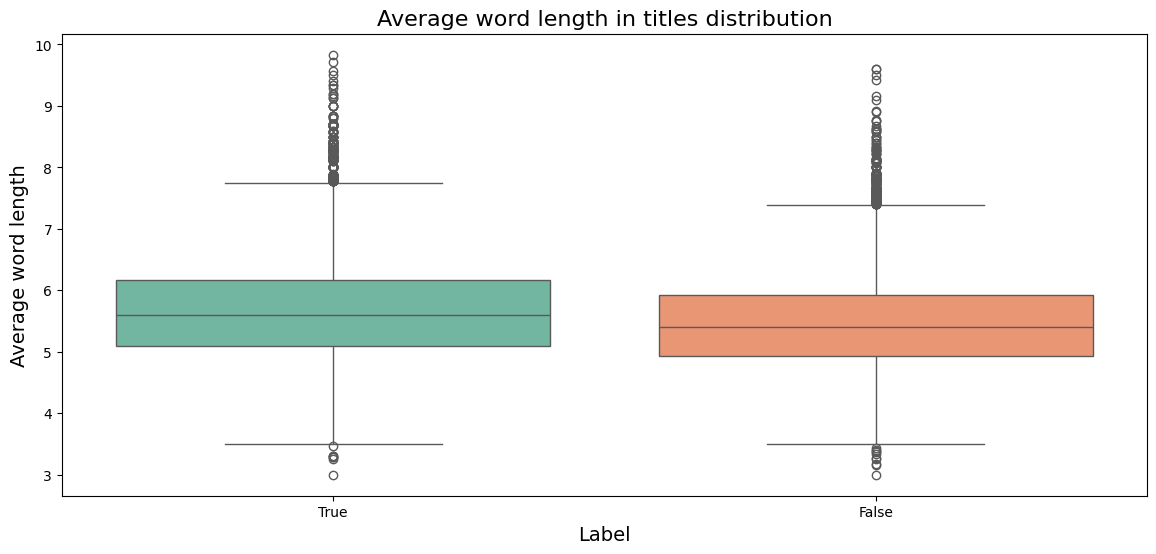

In [141]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='label', y='avg_word_length_title', palette='Set2', hue='label')
plt.title("Average word length in titles distribution", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Average word length", fontsize=14)
plt.show()

In [142]:
average_word_length_titles_threshold = 8

In [143]:
outlier_texts = combined_data[combined_data['avg_word_length_title'] > average_word_length_titles_threshold]

In [144]:
outlier_texts_disp_head = outlier_texts.head(10)

In [145]:
for _, row in outlier_texts_disp_head.iterrows():
    print(f"Text: {row['text']}")
    print(f"Average title word length: {row['avg_word_length_title']:.2f}")
    print("----")

Text: WASHINGTON (Reuters) - U.S. Representative Trent Franks said on Friday that he would resign from Congress effective immediately, instead of the Jan. 31 date he previously had set following the announcement of a probe into accusations of sexual harassment against him. “Last night, my wife was admitted to the hospital in Washington, D.C., due to an ongoing ailment. After discussing options with my family, we came to the conclusion that the best thing for our family now would be for me to tender my previous resignation effective today, December 8th, 2017,” Franks said in an emailed statement. Late on Thursday, Franks, who has represented a district in the Phoenix, Arizona, area since 2003, issued a statement saying that two women on his staff complained that he had discussed with them his efforts to find a surrogate mother, but he denied he had ever “physically intimidated, coerced, or had, or attempted to have, any sexual contact with any member of my congressional staff.” The news

Nothing particualary wrong with these texts.

In [146]:
outlier_texts_disp_tail = outlier_texts.tail(10)

In [147]:
for _, row in outlier_texts_disp_tail.iterrows():
    print(f"Text: {row['text']}")
    print(f"Average title word length: {row['avg_word_length_title']:.2f}")
    print("----")

Text: THIS FIRST-HAND ACCOUNT OF WHAT HAPPENED IN BALTIMORE IS SO SHOCKING AND UNREAL BUT OUR GOOD FRIEND, MATHEW BOYLE, IS ABLE TO TELL US WHAT REALLY HAPPENED: BALTIMORE, Maryland   Racial protests supposed to be peaceful quickly turned into violent riots on Saturday evening, closing down the city of Baltimore for some time and creating a panic for thousands of people as just 50 miles away elites in Washington partied with President Barack Obama at the White House Correspondents  Dinner.Personally, I wasn t supposed to be on the job tonight as a reporter. After a long news week and as several of my contemporaries lived high on the hog down in D.C. at the so-called  Nerd Prom,  me and my brother left D.C. to go see our Boston Red Sox play the Baltimore Orioles at Oriole Park at Camden Yards I hate the White House Correspondents  Dinner it represents everything I think is wrong with Washington, making celebrities out of news media and politicians and given the fact I grew up just outsi

We can see that nothing particulary unusual with these texts. Titles tend to be shorter and if title is longer is cosidered outliying but from the context perspictive we will consider it fine.

In [148]:
combined_data['sentence_count'] = combined_data['text'].apply(calculate_sentence_count)

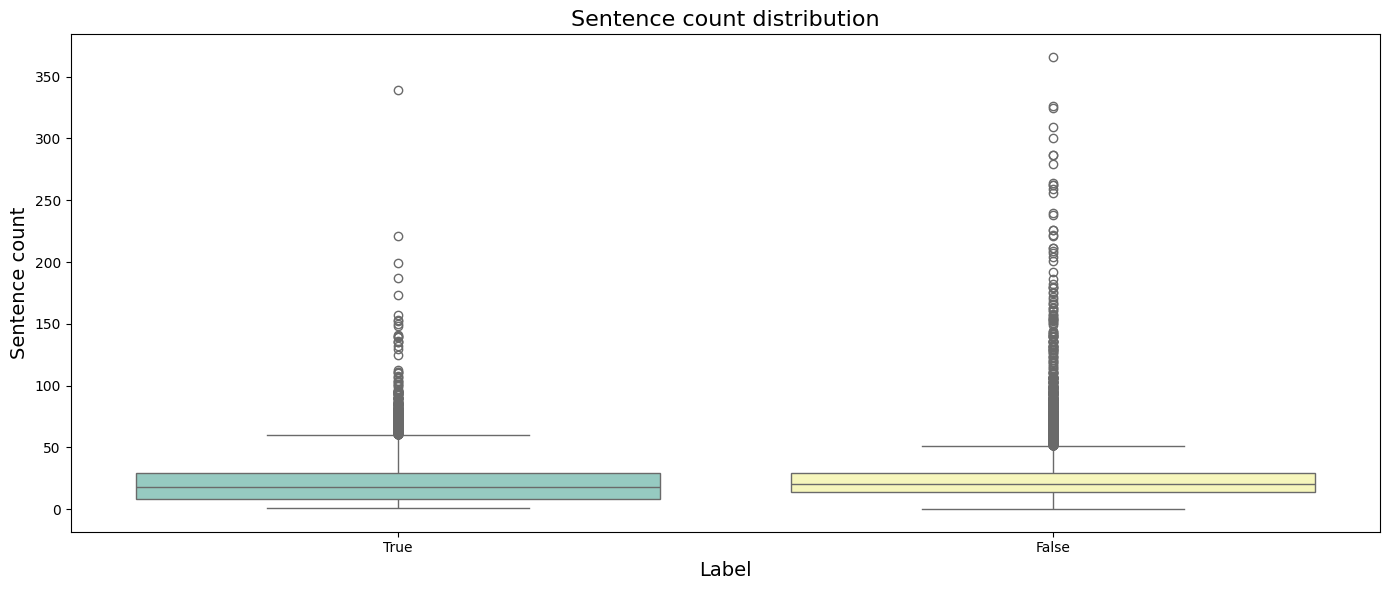

In [149]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='label', y='sentence_count', hue='label', palette='Set3', dodge=False)
plt.title("Sentence count distribution", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Sentence count", fontsize=14)
plt.tight_layout()
plt.show()

While the overall distributions are similar, few articles from "False" texts tend to be slightly more extreme outliers compared to "True" texts.

In [150]:
sentence_count_threshold = 200

In [151]:
true_outliers = combined_data[(combined_data['label'] == "True") & (combined_data['sentence_count'] > sentence_count_threshold)]
false_outliers = combined_data[(combined_data['label'] == "False") & (combined_data['sentence_count'] > sentence_count_threshold)]

In [152]:
for _, row in true_outliers.head(10).iterrows():
    print(f"Text: {row['text']}")
    print(f"Sentence count: {row['sentence_count']}")
    print("----")

Text: (Reuters) - U.S. Environmental Protection Agency Administrator Scott Pruitt gave Reuters a wide-ranging interview on Monday at his office in Washington, discussing issues from climate science to automobile emissions.  The following is a full transcript of the interview: REUTERS: You have said the EPA will focus on a “Back to Basics” approach under your leadership. What does this mean for how EPA enforces polluters? You have been critical of the idea of regulation by enforcement. PRUITT: I think what I’m speaking about there is a consent decree approach to enforcement, where you use judicial proceedings to actually engage in regulation. Enforcement should be about existing regulations that you’re actually enforcing against someone who may be violating that, very much in the prosecutorial manner. As attorney general [in Oklahoma], I lived that. There was a grand jury that I led. Being a prosecutor, I understand very much the importance of prioritization, of enforcing the rule of la

In [153]:
for _, row in false_outliers.head(10).iterrows():
    print(f"Text: {row['text']}")
    print(f"Sentence count: {row['sentence_count']}")
    print("----")

Text: Donald Trump spent Monday night making a total ass out of himself in the first presidential debate. We were all waiting to see just what would happen tonight, and it was quite the spectacle. From lies to self-incrimination, watching the GOP nominee s performance was the equivalent of one facepalm after another.So here you go, a complete list of every batshit crazy thing that came out of Donald Trump s mouth during the first presidential debate: There s nobody in our government to fight them [China], and we have a very good fight, and we have a winning fight. They re using our country as a piggy bank to rebuild China and many other countries are doing the same thing. We have to stop these countries from stealing our companies. Our country s in deep trouble.  We don t know what we re doing with devaluations  Especially when it comes to China, they re the best.  They re the best ever at it. What they re doing to us is a very very sad thing. That s called business, by the way.  (refe

Nothing particulary unusual with these texts.

In [154]:
combined_data['symbol_to_word_ratio'] = combined_data['text'].apply(symbol_to_word_ratio)

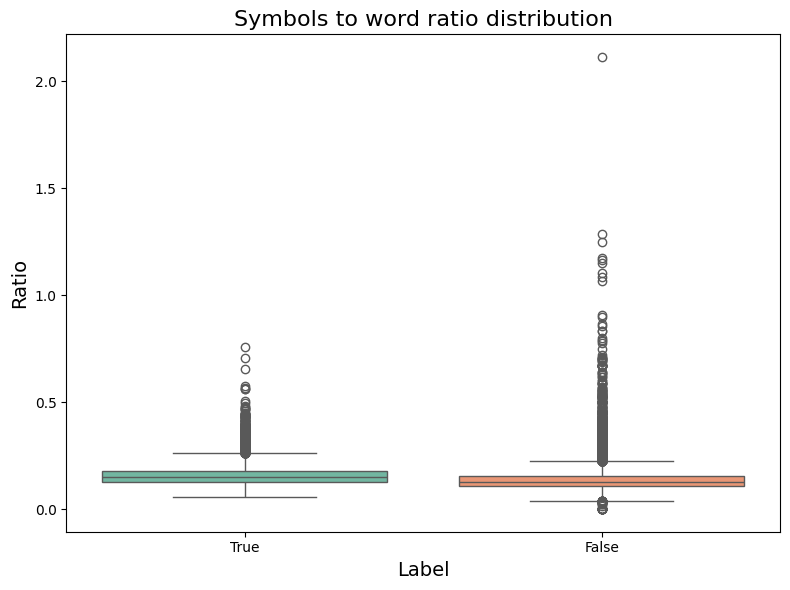

In [155]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_data, x='label', y='symbol_to_word_ratio', hue='label', palette='Set2', dodge=False)
plt.title("Symbols to word ratio distribution", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Ratio", fontsize=14)
plt.tight_layout()
plt.show()

In [156]:
word_threshold = 1

In [157]:
code_heavy_texts = combined_data[
    (combined_data['symbol_to_word_ratio'] > word_threshold)
]

In [158]:
print(len(code_heavy_texts))

9


In [159]:
for _, row in code_heavy_texts.head(10).iterrows():
    print(f"Text: {row['text'][:500]}")
    print(f"Symbol and-word ratio: {row['symbol_to_word_ratio']:.2f}")
    print(f"Sentence count: {row['sentence_count']}")
    print("----")

Text: Notify the CDC. It's spreading. #BenCarson #MorningJoe #TrumpFlu https://t.co/OUseiA7GVs  BCP (@b_c_p_source) October 14, 2016
Symbol and-word ratio: 1.29
Sentence count: 3
----
Text: You re gonna love this patriot! He speaks for each and every one of us who are 100% FED Up! with  offended  Americans! Enjoy this awesome rant and God bless America!// <![CDATA[ (function(d, s, id) { var js, fjs = d.getElementsByTagName(s)[0]; if (d.getElementById(id)) return; js = d.createElement(s); js.id = id; js.src = "//connect.facebook.net/en_US/sdk.js#xfbml=1&#038;version=v2.3"; fjs.parentNode.insertBefore(js, fjs);}(document, 'script', 'facebook-jssdk')); // ]]>HAS AMERICA GONE STUPID? W
Symbol and-word ratio: 1.08
Sentence count: 23
----
Text: // <![CDATA[ (function(d, s, id) { var js, fjs = d.getElementsByTagName(s)[0]; if (d.getElementById(id)) return; js = d.createElement(s); js.id = id; js.src = "//connect.facebook.net/en_GB/sdk.js#xfbml=1&#038;version=v2.3"; fjs.parentNode.insertBefore

Symbols distribution resembles a little bit distributions of sentenses count. These features indeed should correlate longer the text, more symbols will appear.

In [160]:
combined_data = combined_data[
    (combined_data['symbol_to_word_ratio'] <= word_threshold)
].copy()

In [161]:
print(len(combined_data))

38372


In [162]:
combined_data['hashtag_ratio'] = combined_data['text'].apply(lambda x: symbol_ratio(x, '#'))

In [163]:
combined_data['at_ratio'] = combined_data['text'].apply(lambda x: symbol_ratio(x, '@'))

In [164]:
combined_data['quote_ratio'] = combined_data['text'].apply(lambda x: symbol_ratio(x, '"'))

In [165]:
ratio_columns = ['hashtag_ratio', 'at_ratio', 'quote_ratio', 'url_count_ratio']

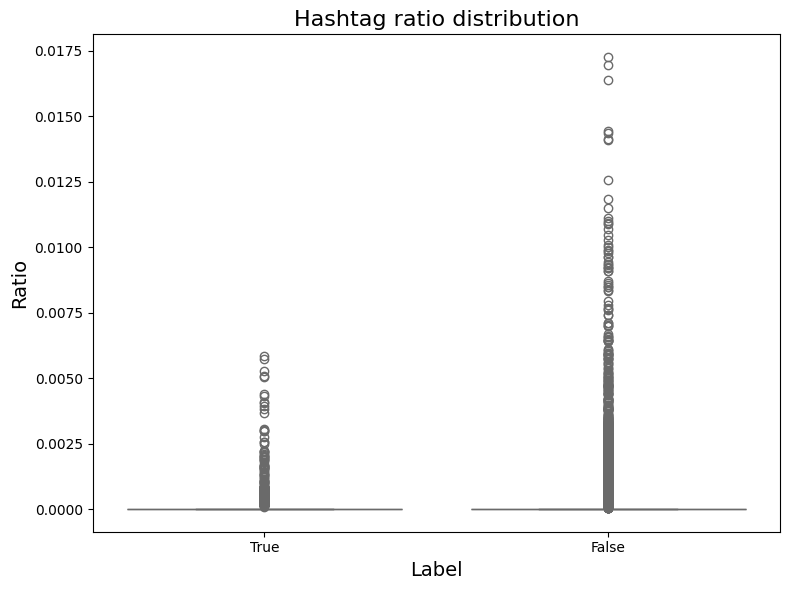

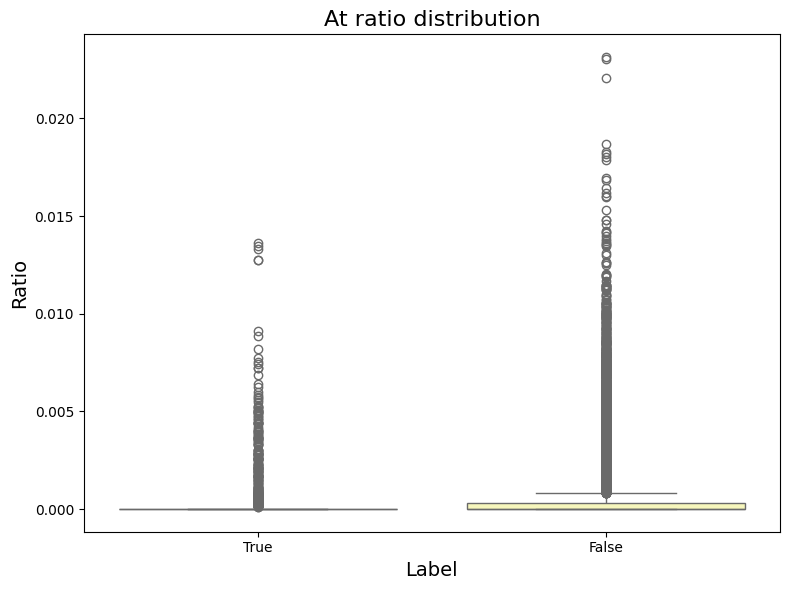

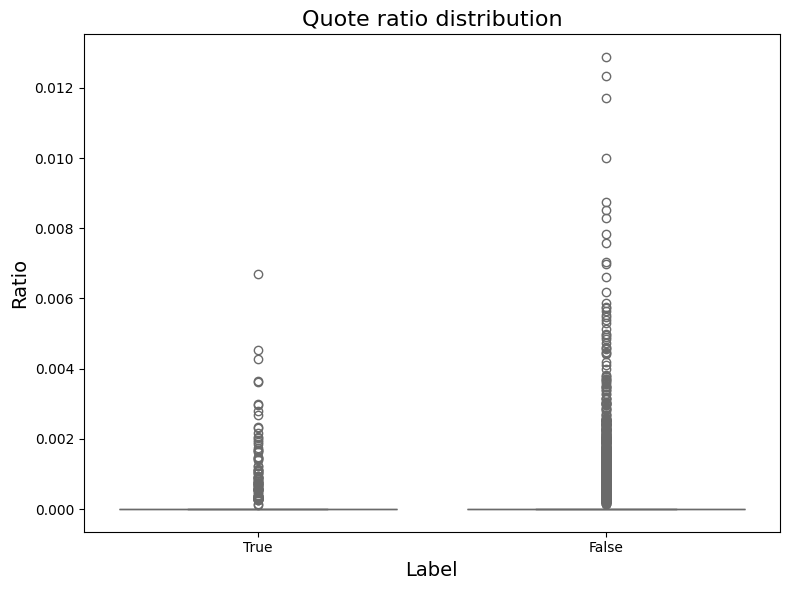

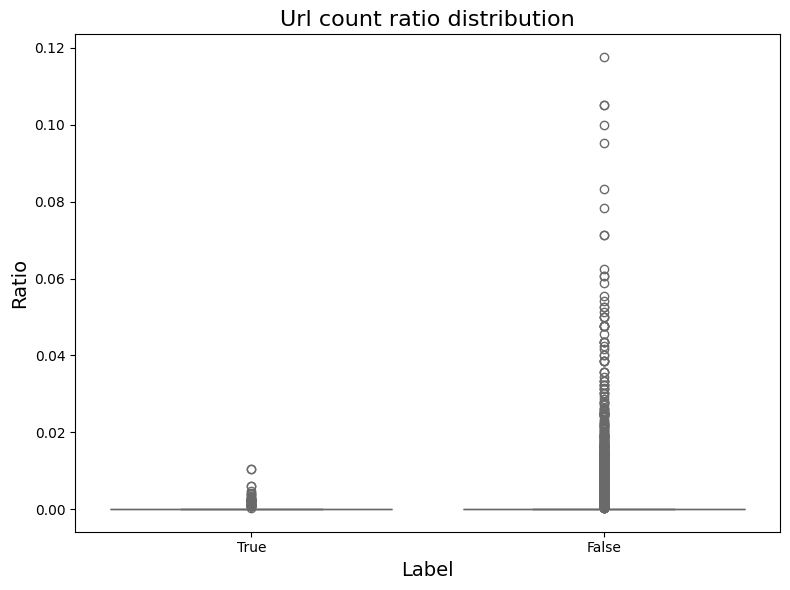

In [166]:
for column in ratio_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=combined_data, x='label', y=column, hue='label', palette='Set3', dodge=False)
    plt.title(f"{column.replace('_', ' ').capitalize()} distribution", fontsize=16)
    plt.xlabel("Label", fontsize=14)
    plt.ylabel("Ratio", fontsize=14)
    plt.tight_layout()
    plt.show()

In [167]:
hashtag_ratio_threshold = 0.01

In [168]:
hashtag_outliers = combined_data[combined_data['hashtag_ratio'] > hashtag_ratio_threshold]

In [169]:
print(len(hashtag_outliers))

18


In [170]:
for _, row in hashtag_outliers.head(10).iterrows():
    print(f"Text: {row['text'][:500]}")
    print(f"Hashtag ratio: {row['hashtag_ratio']:.5f}")
    print(f"At ratio: {row['at_ratio']:.5f}")
    print(f"Quote ratio: {row['quote_ratio']:.5f}")
    print("----")

Text: Earlier today, CBS News and other outlets noticed something strange going on behind the White House. Someone had put up a giant, inflatable chicken that resembled Donald Trump. Now, the hashtag #TrumpChicken is at the top of Twitter s trending list, and for good reason.So many people find the whole thing hilarious. It s probably a good thing that Trump isn t actually in the White House to see it right now, although it s a good bet that, if he knows about it, he s fuming.And the popularity of #Tr
Hashtag ratio: 0.01113
At ratio: 0.00693
Quote ratio: 0.00000
----
Text: When you bring #NeverTrumper @greggutfeld on-board the #TrumpTrain, you re doing something right! #MAGA pic.twitter.com/5Rx2HtAzcq  Boston Bobblehead (@DBloom451) March 14, 2017
Hashtag ratio: 0.01695
At ratio: 0.01130
Quote ratio: 0.00000
----
Text: FOX News  Catherine Herridge exposes the dirty tactics of Barack Obama and his secretive efforts to undermine President Trump No EX-POTUS in 100 yrs has set up a #Shadow

In [171]:
url_ratio_threshold = 0.1

In [172]:
url_outliers = combined_data[combined_data['url_count_ratio'] > url_ratio_threshold]

In [173]:
print(len(url_outliers))

3


In [174]:
for _, row in url_outliers.head(10).iterrows():
    print(f"Text: {row['text'][:500]}")
    print(f"URL ratio: {row['url_count_ratio']:.5f}")
    print(f"Hashtag ratio: {row['hashtag_ratio']:.5f}")
    print(f"At ratio: {row['at_ratio']:.5f}")
    print(f"Quote ratio: {row['quote_ratio']:.5f}")
    print("----")

Text: Line of the night from Cohen: These accusations against Trump have themselves become a grave national security threat! https://www.youtube.com/watch?v=DdCUDSFE3fI
URL ratio: 0.10526
Hashtag ratio: 0.00000
At ratio: 0.00000
Quote ratio: 0.00000
----
Text: This is a clip of Kellyanne Conway and Jen Palmeieri getting into it: https://www.youtube.com/watch?v=zQbv1SAu9R4 The entire debate: 
URL ratio: 0.11765
Hashtag ratio: 0.00000
At ratio: 0.00000
Quote ratio: 0.00000
----
Text: Kellyanne Conway defends Trump s  Hamilton  twitter scrap:  Why do you care https://t.co/11UIp8cKFi https://t.co/vnk4rOhY4m  CNN (@CNN) November 21, 2016
URL ratio: 0.10526
Hashtag ratio: 0.00000
At ratio: 0.00654
Quote ratio: 0.00000
----


We can very clearly see that false text have more and often more etreme outlier of these symbols ratios. Text are what some clean, they just have hashtags, tagging, links and in general symbols. They will probably be important features if we base our classification on these texts characteristics.

In [175]:
combined_data['capital_letters_ratio_text'] = combined_data['text'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

In [176]:
combined_data['question_mark_count_text'] = combined_data['text'].apply(lambda x: x.count("?"))

In [177]:
combined_data['exclamation_mark_count_text'] = combined_data['text'].apply(lambda x: x.count("!"))

In [178]:
combined_data['ellipses_count_text'] = combined_data['text'].apply(lambda x: x.count("..."))

In [179]:
special_characters = "!@#$%^&*()_-+=[]{}|\\:;\"'<>,.?/~"

In [180]:
combined_data['special_char_ratio_text'] = combined_data['text'].apply(
    lambda x: sum(1 for c in x if c in special_characters) / len(x) if len(x) > 0 else 0
)

In [181]:
new_columns = [
    'capital_letters_ratio_text', 'question_mark_count_text',
    'exclamation_mark_count_text', 'ellipses_count_text',
    'special_char_ratio_text'
]

<ipython-input-182-a8b568ed84a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='label', y=column, palette='Set3')


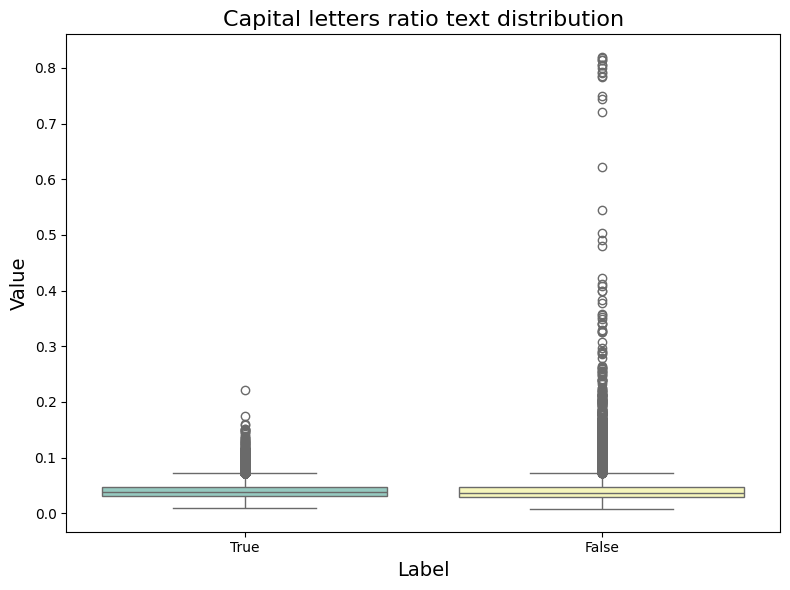

<ipython-input-182-a8b568ed84a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='label', y=column, palette='Set3')


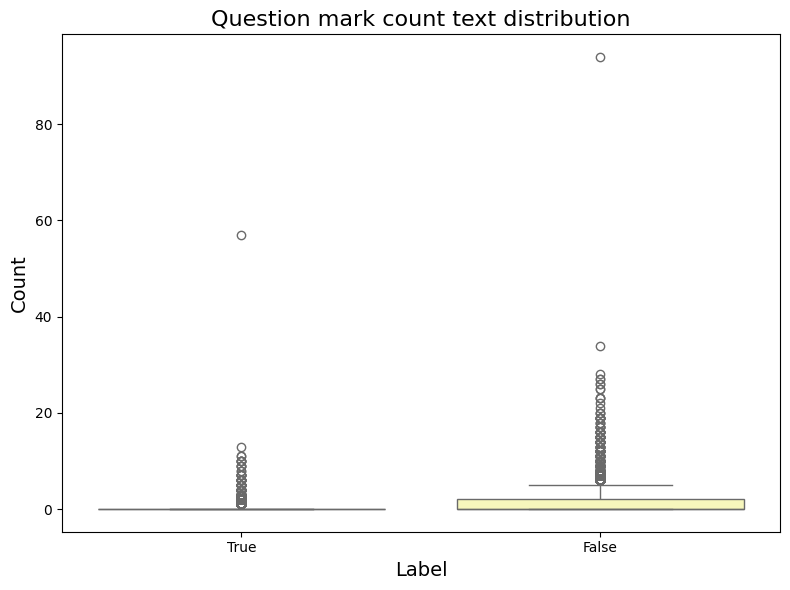

<ipython-input-182-a8b568ed84a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='label', y=column, palette='Set3')


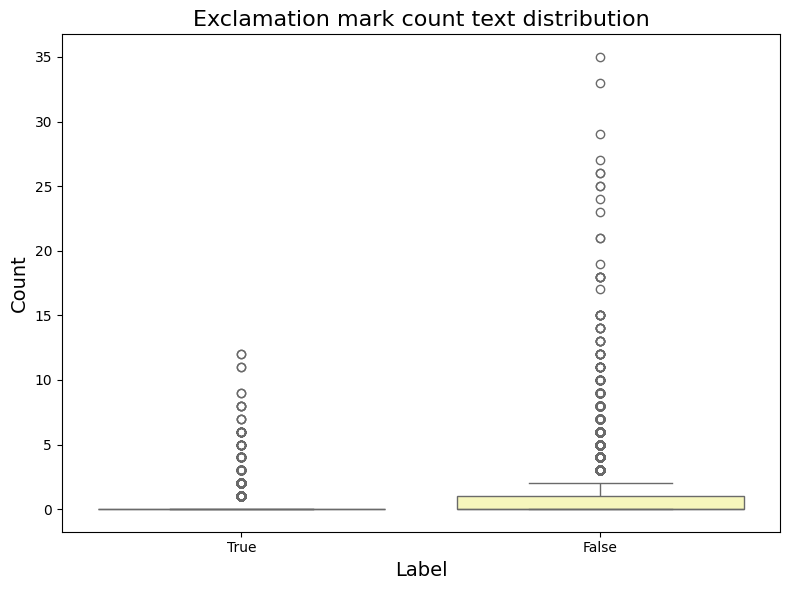

<ipython-input-182-a8b568ed84a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='label', y=column, palette='Set3')


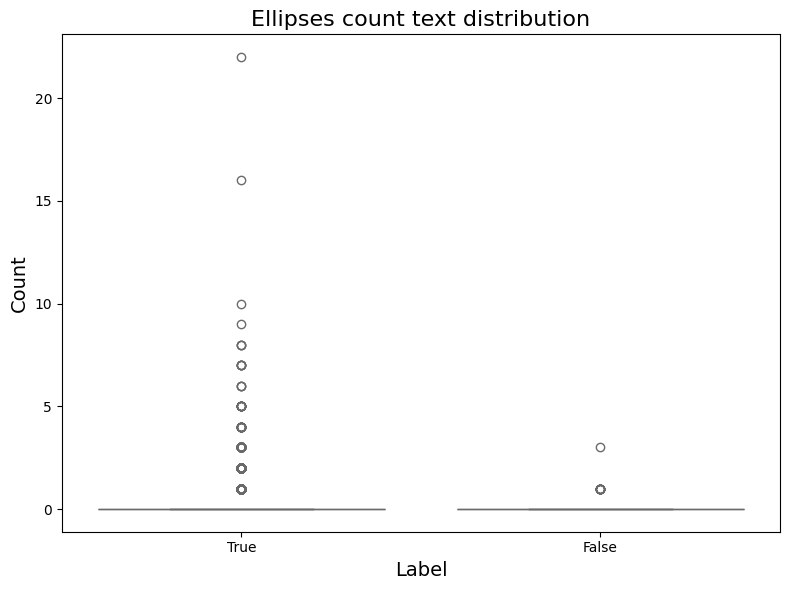

<ipython-input-182-a8b568ed84a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='label', y=column, palette='Set3')


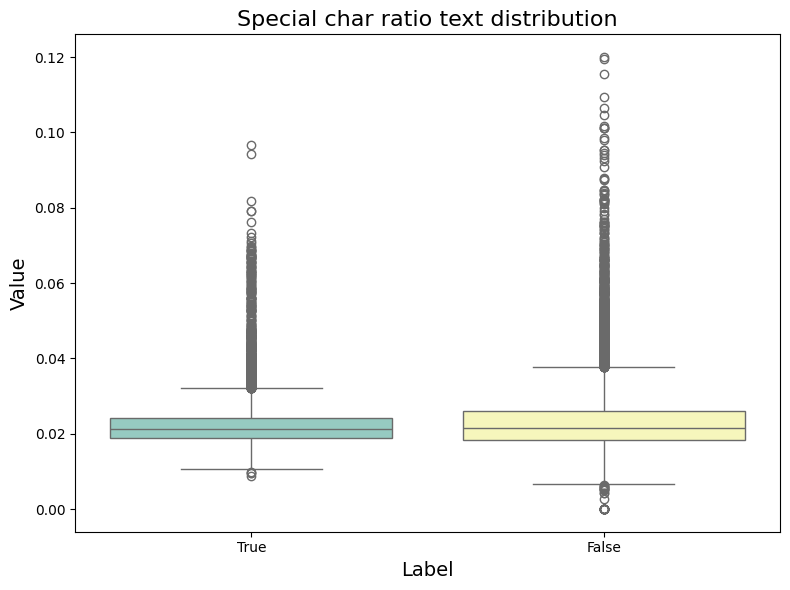

In [182]:
for column in new_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=combined_data, x='label', y=column, palette='Set3')
    plt.title(f"{column.replace('_', ' ').capitalize()} distribution", fontsize=16)
    plt.xlabel("Label", fontsize=14)
    plt.ylabel("Value" if "ratio" in column else "Count", fontsize=14)
    plt.tight_layout()
    plt.show()

We can see the same trend with these symbols as well, except we can see that false text use less ellipses than true texts. Nevetheless texts looks more or less clean we will use these features in some modeling parts, some outliers have been deleted considering that we will try to see if any deep learning methods are better in this case or unnecessary. Finally important indicator could stop words ratio, less rich language could be using more of these and therefor might be distinguising factor.

In [183]:
combined_data['stop_word_count_title'] = combined_data['title'].apply(count_stop_words)

In [184]:
combined_data['stop_word_ratio_title'] = combined_data['stop_word_count_title'] / combined_data['title_word_count']

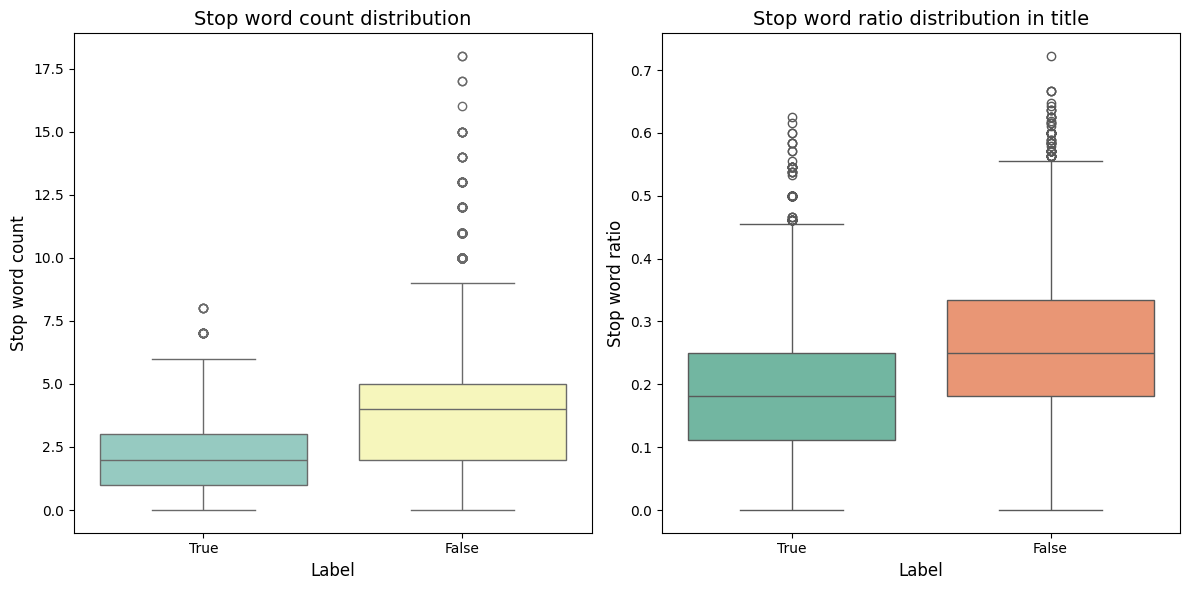

In [185]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(
    data=combined_data,
    x='label',
    y='stop_word_count_title',
    hue='label',
    palette='Set3',
    dodge=False
)
plt.title('Stop word count distribution', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Stop word count', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(
    data=combined_data,
    x='label',
    y='stop_word_ratio_title',
    hue='label',
    palette='Set2',
    dodge=False
)
plt.title('Stop word ratio distribution in title', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Stop word ratio', fontsize=12)
plt.tight_layout()
plt.show()

As one could have suspected since false text should be less linguisticly rich they use more stop words.

In [186]:
label_counts = combined_data['label'].value_counts(normalize=True)
print("Label proportions after:")
print(label_counts)

Label proportions after:
label
True     0.552252
False    0.447748
Name: proportion, dtype: float64


In [187]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38372 entries, 0 to 43279
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   title                           38372 non-null  object 
 1   text                            38372 non-null  object 
 2   subject                         38372 non-null  object 
 3   date                            38372 non-null  object 
 4   label                           38372 non-null  object 
 5   cleaned_text                    38372 non-null  object 
 6   cleaned_title                   38372 non-null  object 
 7   cleaned_and_without_stop_text   38372 non-null  object 
 8   cleaned_and_without_stop_title  38372 non-null  object 
 9   char_count                      38372 non-null  int64  
 10  word_count                      38372 non-null  int64  
 11  unique_word_count               38372 non-null  int64  
 12  title_char_count                38372

**Correlation**

In [188]:
combined_data['numeric_label'] = combined_data['label'].replace({'True': 1, 'False': 0})

<ipython-input-188-248b39b74851>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_data['numeric_label'] = combined_data['label'].replace({'True': 1, 'False': 0})


In [189]:
numeric_features = combined_data.select_dtypes(include=['int64', 'float64']).copy()

In [190]:
correlation_matrix = numeric_features.corr()

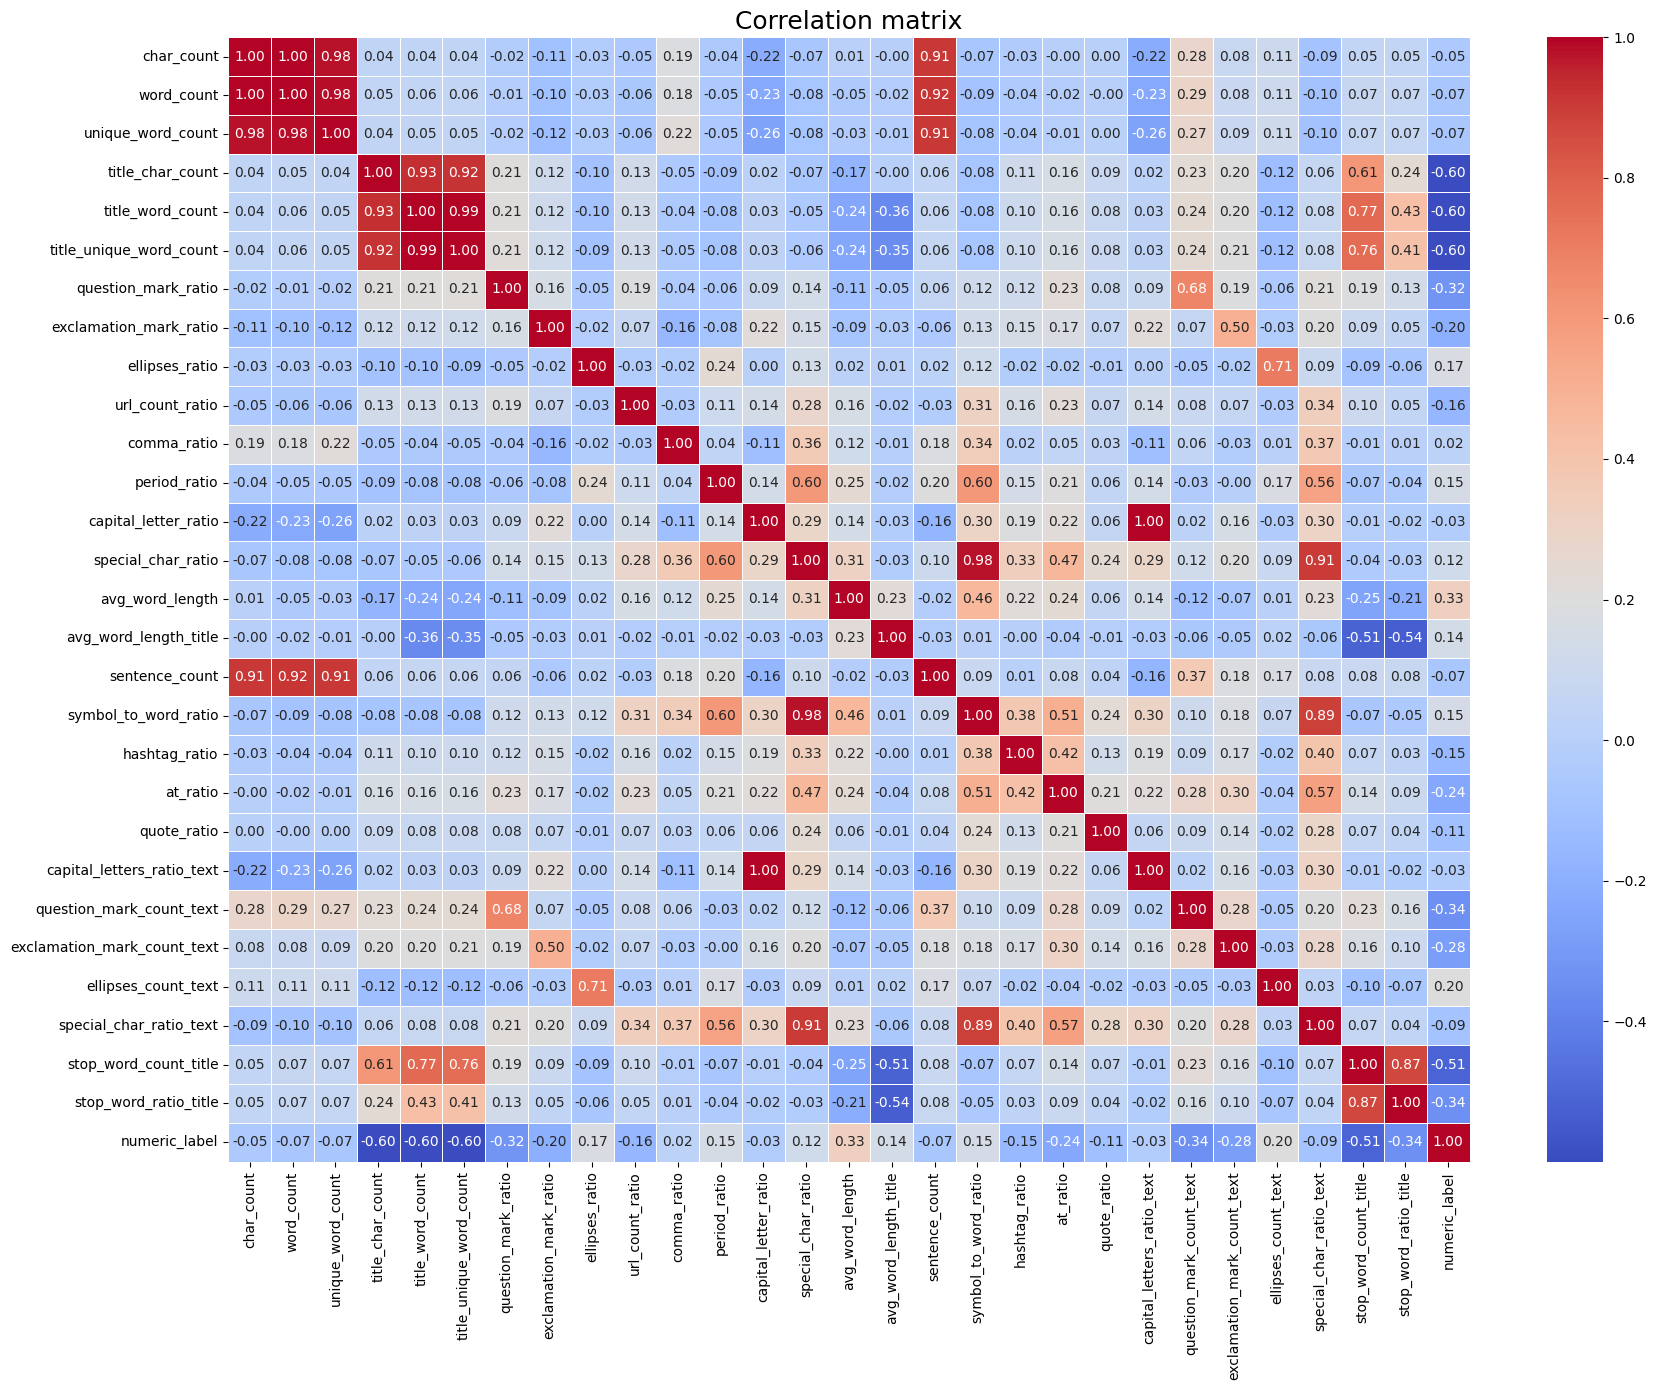

In [191]:
plt.figure(figsize=(18, 14))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation matrix", fontsize=18)
plt.tight_layout()
plt.show()

Char count, word count, unique word count and sentence count are highly correlated which is expected because texts with more characters naturally tend to have more words and sentences. These features capture similar aspects of text and may provide redundant information in some models. Same can be noticed among these features of title text.

Title char, word, and unique word counts are moderately negatively correlated with the label, suggesting that articles with longer and more diverse titles are more likely to be labeled as false and shorter titles tend to be associated with true articles. There is also a moderate negative correlation between label and stop words words counts in title.

Highest positive correlation of 0.33 with the label is average word length meaning that texts with longer average word lengths are more likely to be labeled as true.


### TF-IDF scores correlation to the label.

In [192]:
tfidf = TfidfVectorizer(max_features=500)

In [193]:
tfidf_matrix = tfidf.fit_transform(combined_data["cleaned_and_without_stop_text"])

In [194]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [195]:
tfidf_df["label"] = combined_data["label"].map({"True": 1, "False": 0}).values

In [196]:
correlation_results = {
    feature: spearmanr(tfidf_df[feature], tfidf_df["label"]).correlation
    for feature in tfidf_df.columns[:-1]
}

In [197]:
sorted_correlation = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)

In [198]:
top_features = sorted_correlation[:10]

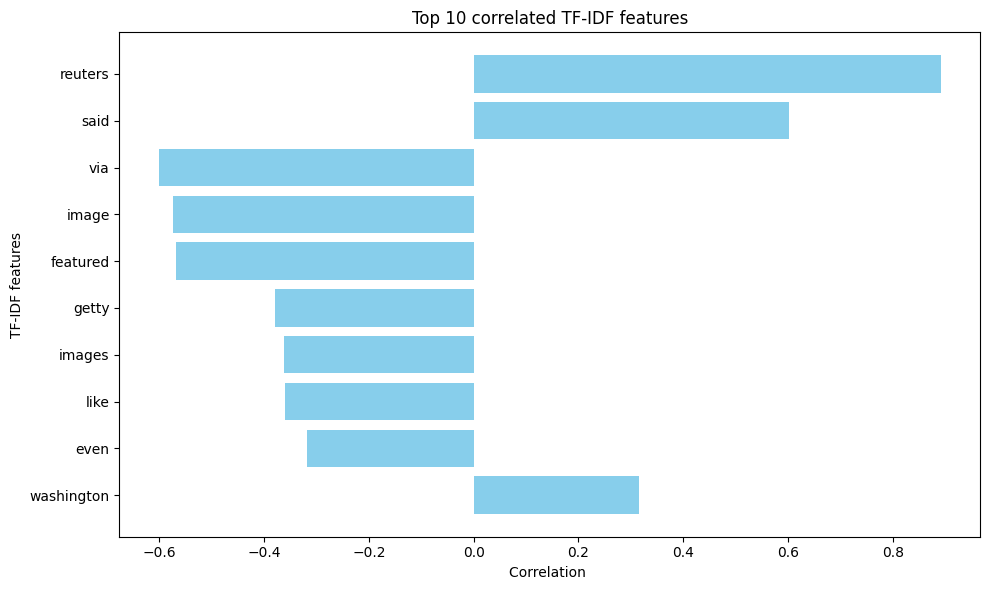

In [199]:
top_terms, top_correlations = zip(*top_features)
plt.figure(figsize=(10, 6))
plt.barh(top_terms, top_correlations, color="skyblue")
plt.xlabel("Correlation ")
plt.ylabel("TF-IDF features")
plt.title("Top 10 correlated TF-IDF features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Words like reuters, said and via show strongest correlations with the label, epecially reuter. If left they can create strong bias to the model.

### Timeseries analysis

We also know that we have time stamp of the text.

In [200]:
combined_data['date'] = combined_data['date'].str.strip()

In [201]:
combined_data['parsed_date'] = pd.to_datetime(combined_data['date'], format='%B %d, %Y', errors='coerce')

We need to check if any dates are misssing or formatted different way.

In [202]:
missing_date_rows = combined_data[combined_data['parsed_date'].isnull()]

In [203]:
print(f"Number of rows with issues: {len(missing_date_rows)}")

Number of rows with issues: 6644


In [204]:
print("Unresolved rows:")
print(missing_date_rows[['date']].drop_duplicates().head(5))

Unresolved rows:
            date
30260  19-Feb-18
30263  18-Feb-18
30270  17-Feb-18
30277  16-Feb-18
30285  15-Feb-18


In [205]:
combined_data.loc[missing_date_rows.index, 'parsed_date'] = pd.to_datetime(
        missing_date_rows['date'], format='%d-%b-%y', errors='coerce'
    )

In [206]:
still_missing_rows = combined_data[combined_data['parsed_date'].isnull()]
print(f"Number of rows still unresolved: {len(still_missing_rows)}")

Number of rows still unresolved: 6609


In [207]:
print("Unresolved rows:")
print(still_missing_rows[['date']].drop_duplicates().head(5))

Unresolved rows:
               date
30295  Dec 31, 2017
30299  Dec 30, 2017
30305  Dec 29, 2017
30314  Dec 28, 2017
30317  Dec 27, 2017


In [208]:
combined_data.loc[combined_data['parsed_date'].isnull(), 'parsed_date'] = pd.to_datetime(
    combined_data.loc[combined_data['parsed_date'].isnull(), 'date'],
    format='%b %d, %Y',
    errors='coerce'
)

In [209]:
still_missing_rows = combined_data[combined_data['parsed_date'].isnull()]

In [210]:
print(f"Number of rows still unresolved: {len(still_missing_rows)}")

Number of rows still unresolved: 0


In [211]:
combined_data['year'] = combined_data['parsed_date'].dt.year
yearly_distribution = combined_data.groupby(['year', 'label']).size().unstack()

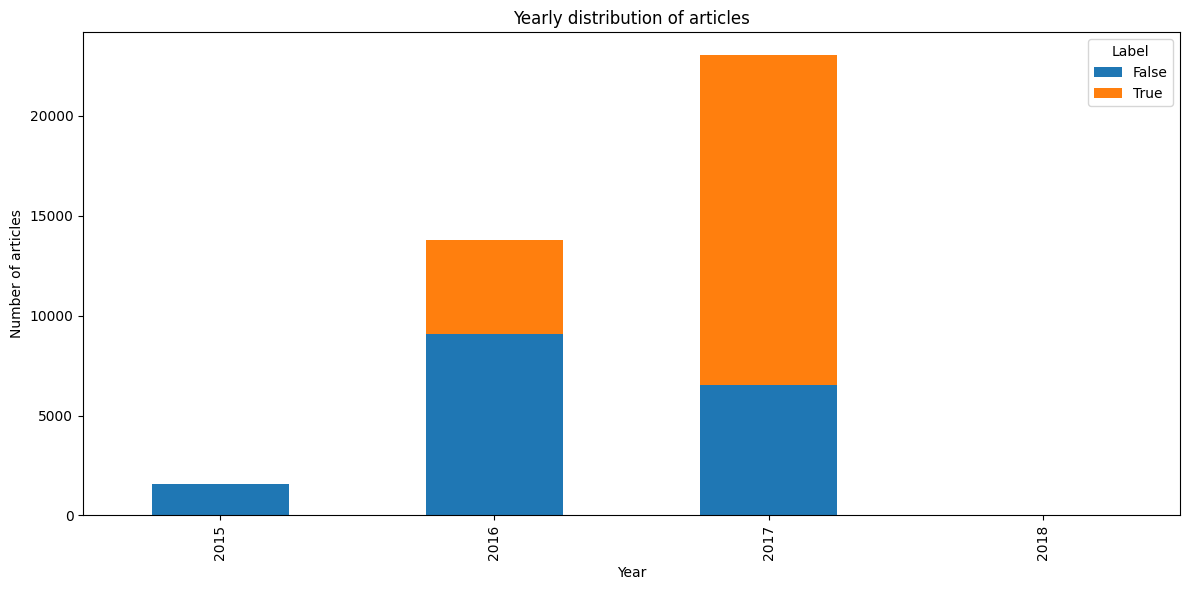

In [212]:
yearly_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Yearly distribution of articles')
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

We can see few things. We have almost by 10000 text more from 2017. Also 2016 were dominated by false text. In our context analysis before we saw how strongly political these texts are so we can make an assumption but only assumption that this might be due to the election year in the USA.

In [213]:
combined_data['month'] = combined_data['parsed_date'].dt.month
monthly_distribution = combined_data.groupby(['month', 'label']).size().unstack()

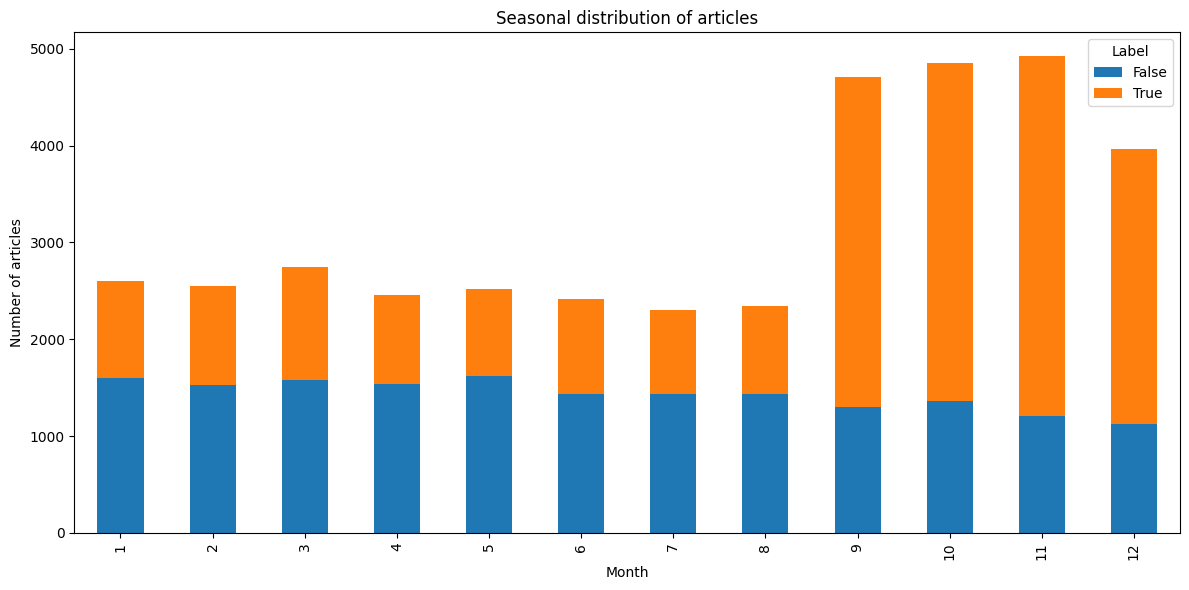

In [214]:
monthly_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Seasonal distribution of articles')
plt.xlabel('Month')
plt.ylabel('Number of articles')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

We can see that false texts are more constant in volume if we combine by each month and last months of the year have an increased number of truthfull texts.

In [215]:
combined_data['month'] = combined_data['parsed_date'].dt.month

In [216]:
monthly_counts = combined_data.groupby(['month', 'label']).size().unstack()

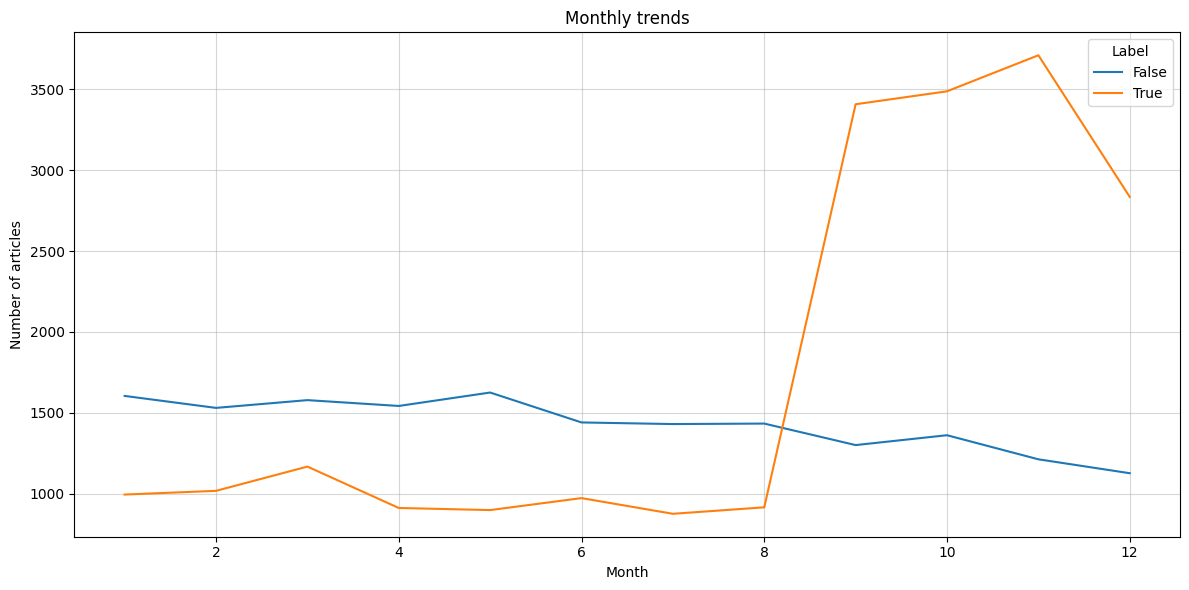

In [217]:
monthly_counts.plot(kind='line', figsize=(12, 6))
plt.title('Monthly trends')
plt.xlabel('Month')
plt.ylabel('Number of articles')
plt.legend(title='Label')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [218]:
yearly_monthly_distribution = combined_data.groupby(['year', 'month', 'label']).size().unstack()

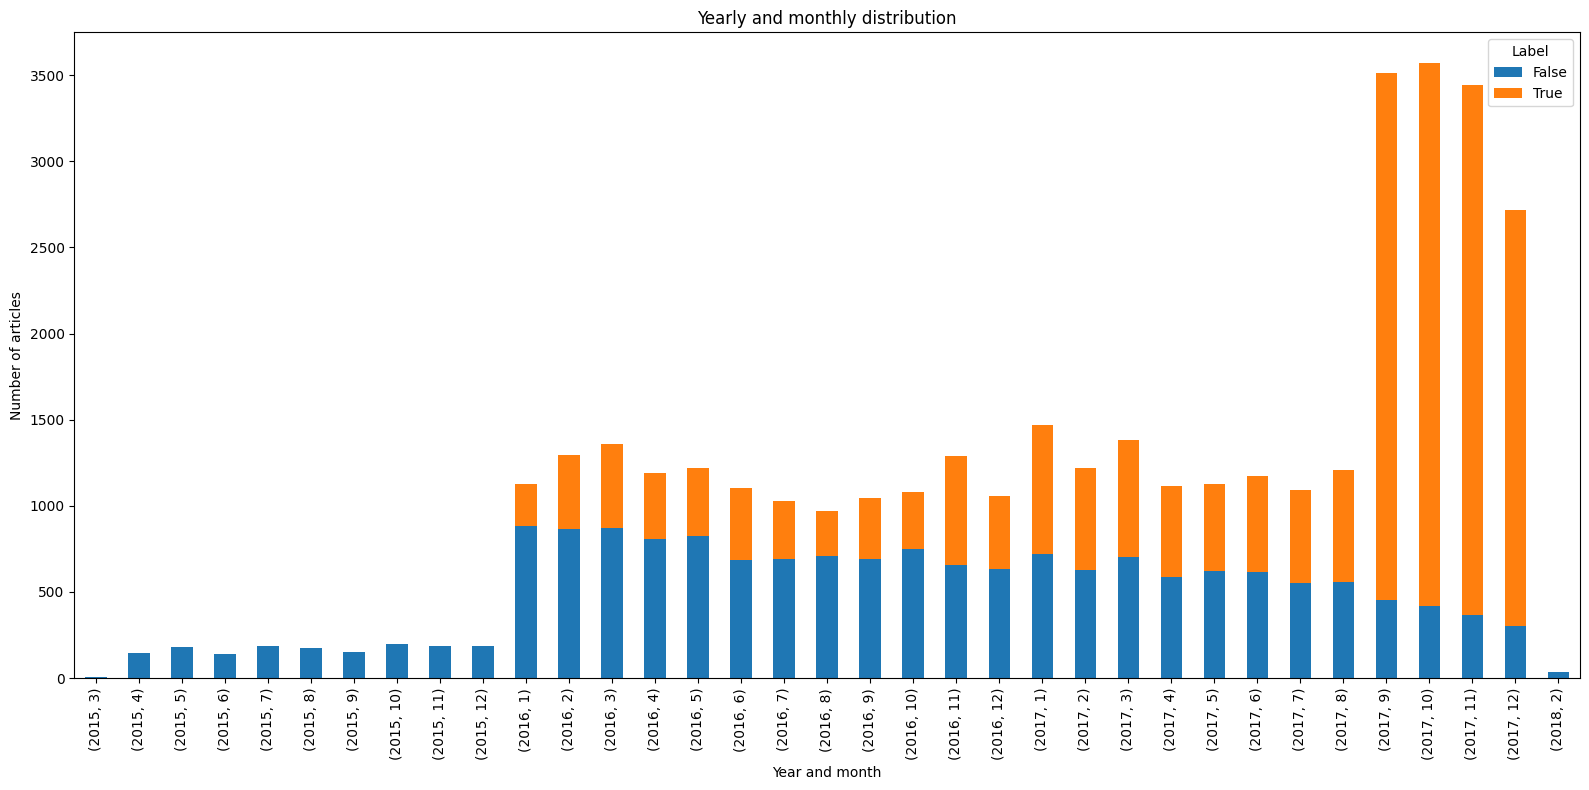

In [219]:
yearly_monthly_distribution.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.title('Yearly and monthly distribution')
plt.xlabel('Year and month')
plt.ylabel('Number of articles')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

from 2015 and 2018 we only have false text and we can see that before noticed increase in last months of the year is mostly accounted to 2017 which has several times more truthfull texts than false, which can't be noticed for other years. We know that at the end of 2016 facebook implemented fact checking policy, also not long time ago before world recognized the issue of false texts so called fake news and misleading articles. There were more public discussion regarding that issue. We might be able to see some effects of these actions and discussions.

In [220]:
output_file = "combined_data_cleaned.csv"
combined_data.to_csv(output_file, index=False)

### EDA Summary

The dataset originally contained duplicates and empty texts. After all cleaning we are left with 38372

There is a slight imbalance with more true articles than false ones after cleaning true articles about 55% and false 45%.

Using statistical metrics such as word count and average word length several outliers were identified. These outliers included nonsensical words, code like text in mostly false text and were removed.

Common words in true articles included Washington and reuters emphasizing text sources, while false articles highlighted words like twitter and various political figures.

Top TF-IDF scores in true articles were words like said, reuters and government, while false often featured social media terms and political figures. This highlights a potential biases toward distinguishing true and false articles based on topics.

False texts had higher word counts, character counts and unique word count suggesting more diverse content compared to true.

Titles text often resembled text patterns.

Various feature were engineering following this analyis: ratios of question marks, exclamation points, capital letters, hyperlinks, stops words and others. We will use these features as input for texts label classification.